## Single axis and small fit domain test

In [1]:
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from electrode import (System, PolygonPixelElectrode, euler_matrix,
    PointPixelElectrode, PotentialObjective,
    PatternRangeConstraint, shaped, utils)
from scipy.signal import argrelextrema
import math
from scipy.optimize import minimize
import json
import pandas as pd
from datetime import datetime
from scipy.optimize import linprog

In [2]:
def save_trap(el_map, name='quetzal'):
    el_dict = dict(el_map)
# # Convert and write JSON object to file
    with open(str(name) + ".json", "w") as outfile: 
        json.dump(el_dict, outfile)


In [3]:
# n electrodes per row (10 default)
# number of rows (2 default)
# width of electrode
# height of electrode
# spacing between electrodes
# tuple of coordinates to start each row
    # top row x-coordinate (bottom left point)
    # top row y-coordinate (bottom left point)

#...
# bottom row x-coordinate (bottom left point)
# bottom row y-coordinate (bottom left point)
def trap(spacing,
        gnd_width, gnd_height, gnd_start_pos,
        dc_width, dc_height, dc_start_pos,
        rf_width, rf_height, rf_start_pos,
        dc_mid_width, dc_mid_height, dc_mid_start_pos,
        n=9, r=2):

    electrodes = []

    #add dc electrodes
    #define effective size, without dielectric gaps
    w_eff = dc_width + spacing
    h_eff = dc_height + spacing
    #start with top row
    row = 0
    for sp in dc_start_pos:
        xp_start = sp[0] - spacing/2
        yp = sp[1] - spacing/2
        for electrode in range(n):
            # e.g. electrode 2 would be leftmost in top row
            # e.g. electrode 12 would be leftmost in bottom row
            electrode_id = str(row * (n+1) + electrode + 2)
            x_shift = electrode * w_eff
            xp = xp_start + x_shift
            # print(xp)
            electrodes.append(
                (electrode_id, [[
                    (xp, yp),
                    (xp + w_eff, yp),
                    (xp + w_eff, yp + h_eff),
                    (xp, yp + h_eff)
                ]])
            )
        row += 1
    dc_mid_w_eff = dc_mid_width + spacing
    dc_mid_h_eff = dc_mid_height + spacing
    for i in range (2):
        xp = dc_mid_start_pos[i][0] - spacing/2
        yp = dc_mid_start_pos[i][1] - spacing/2
        dc_mid_id = str(10*i + 1)
        electrodes.append(
            (dc_mid_id, [[
                (xp, yp),
                (xp + dc_mid_w_eff, yp),
                (xp + dc_mid_w_eff, yp + dc_mid_h_eff),
                (xp, yp + dc_mid_h_eff)
            ]])
        )
    
    # add rf electrodes
    rf_w_eff = rf_width + spacing
    rf_h_eff = rf_height + spacing
    rf_electrodes = []
    for i in range (2):
        xp = rf_start_pos[i][0] - spacing/2
        yp = rf_start_pos[i][1] - spacing/2
        # rf_e_id = str('r'+i+1) #use this for unique rf electrode id
        rf_electrodes.append([
            (xp, yp),
            (xp + rf_w_eff, yp),
            (xp + rf_w_eff, yp + rf_h_eff),
            (xp, yp + rf_h_eff)
        ])
        rf_e_id = str('r')
    electrodes.append(
        (rf_e_id, rf_electrodes)
    )
    
    # add gnd electrodes
    #define effective size, without dielectric gaps
    gnd_w_eff = gnd_width + spacing
    gnd_h_eff = gnd_height + spacing
    gnd_electrodes = []
    for sp in gnd_start_pos:
        xp = sp[0] - spacing/2
        yp = sp[1] - spacing/2
        for gnd in range(n):
            gnd_id = 'gnd'
            gnd_electrodes.append([
                (xp, yp),
                (xp + gnd_w_eff, yp),
                (xp + gnd_w_eff, yp + gnd_h_eff),
                (xp, yp + gnd_h_eff)
            ])
    electrodes.append(
        (gnd_id, gnd_electrodes)
    )
    
    s = System([PolygonPixelElectrode(name=n, paths=map(np.array, p))
                for n, p in electrodes])
    # apply rf potential to electrode
    # s['r'].rf = 1.
    save_trap(electrodes)
    return s

[[-500.   602.5]]


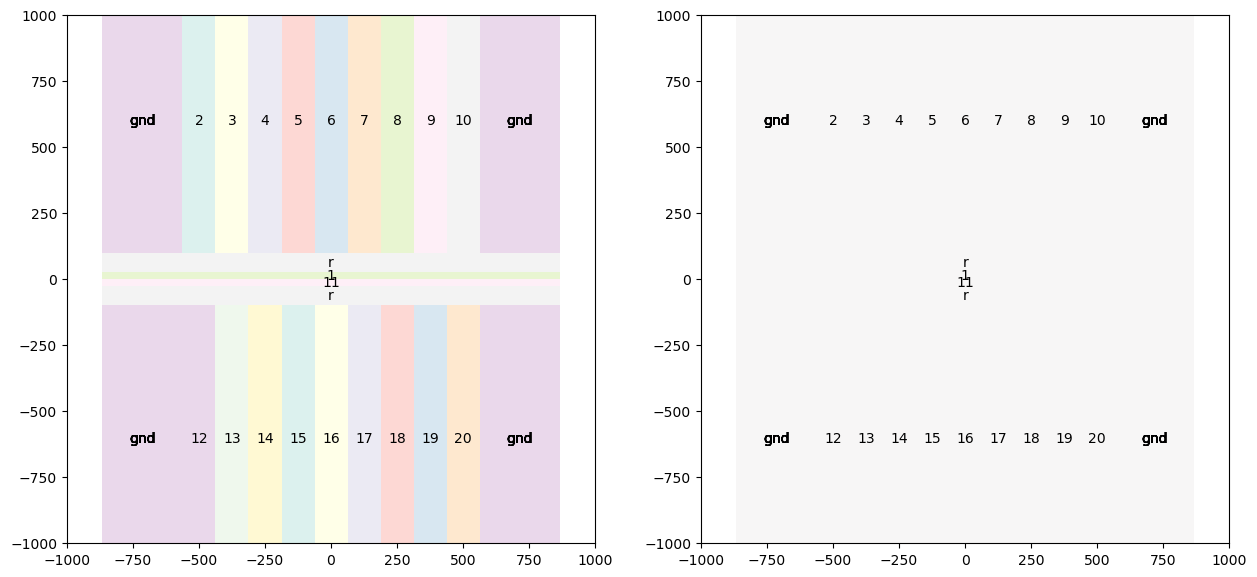

In [4]:
spacing = 5.
n = 9
dc_width = 120.
# dc_height = 1000.
gnd_width = 300.
gnd_height = 1000.
dc_height = 1000.
dc_mid_height = 20.
# dc_mid_width = n * dc_width + (n-1) * spacing
dc_mid_width = n * dc_width + (n+1) * spacing + 2 * gnd_width
rf_height = 70.
# rf_width = n * dc_width + (n-1) * spacing
rf_width = n * dc_width + (n+1) * spacing + 2 * gnd_width

leftmost_electrode_x = -(4.5*dc_width + 4*spacing)
rightmost_electrode_x = (4.5*dc_width + 4*spacing)

gnd_start_pos = [(leftmost_electrode_x-gnd_width-spacing, (2.5*spacing + dc_mid_height + rf_height)),
                (leftmost_electrode_x-gnd_width-spacing, -(2.5*spacing + dc_mid_height + rf_height + dc_height)),
                (rightmost_electrode_x+spacing, (2.5*spacing + dc_mid_height + rf_height)),
                (rightmost_electrode_x+spacing, -(2.5*spacing + dc_mid_height + rf_height + dc_height))
                ]

dc_start_pos = [(leftmost_electrode_x, (2.5*spacing + dc_mid_height + rf_height)),
                (leftmost_electrode_x, -(2.5*spacing + dc_mid_height + rf_height + dc_height))]
rf_start_pos = [(leftmost_electrode_x-gnd_width-spacing, (1.5*spacing + dc_mid_height)),
                (leftmost_electrode_x-gnd_width-spacing, -(1.5*spacing + dc_mid_height + rf_height))]
dc_mid_start_pos = [(leftmost_electrode_x-gnd_width-spacing, (.5*spacing)),
                (leftmost_electrode_x-gnd_width-spacing, -(.5*spacing +dc_mid_height))]

s = approx_trap(spacing,
        gnd_width, gnd_height, gnd_start_pos,
        dc_width, dc_height, dc_start_pos,
        rf_width, rf_height, rf_start_pos,
        dc_mid_width, dc_mid_height, dc_mid_start_pos,
        n, r=2)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
print(s["2"].to_points().points) # use this to get the centroid coordinates of an electrode
s.plot(ax[0])
# s.plot_voltages(ax[1], u=s.rfs)
# s['2'].dc = 1.
s.plot_voltages(ax[1])

r= 1000
for axi in ax.flat:
    axi.set_aspect("equal")
    axi.set_xlim(-r, r)
    axi.set_ylim(-r, r)

In [5]:
l = 1e-6 # µm length scale
u = 10. # V rf peak voltage
m = 40*ct.atomic_mass # 40Ca+ ion mass
q = 1*ct.elementary_charge # ion charge

f = 30e6
o = 2*np.pi*f # rf frequency in rad/s
s["r"].rf = u*np.sqrt(q/m)/(2*l*o)

# searches for potential minimum point given the starting point
x0 = s.minimum((0, 0, 1.), axis=(1, 2))
z_h = x0[2]
# using lengthscale 1e-6 m gives the right height for minimum at 50µm
# x0 = np.array([0.0, 0.0, 50.0])
# print(x0)

for line in s.analyze_static(x0, axis=(1, 2), m=m, q=q, l=l, o=o):
    print(line)

parameters:
 f=30 MHz, m=40 amu, q=1 qe, l=1 µm, scale=4.12 V'/V_SI
corrdinates:
 analyze point: [0.00000000e+00 4.34002626e-15 4.97375282e+01]
               ([0.00000000e+00 4.34002626e-15 4.97375282e+01] µm)
 minimum is at offset: [0. 0. 0.]
                      ([0. 0. 0.] µm)
potential:
 dc electrical: 0 eV
 rf pseudo: 1.6e-09 eV
 saddle offset: [-1.74598588e-01  4.01329185e-08  7.90990106e-03]
               ([-1.74598588e-01  4.01329185e-08  7.90990106e-03] µm)
 saddle height: -1.6e-09 eV
force:
 dc electrical: [0. 0. 0.] eV/l
               ([0. 0. 0.] eV/m)
 rf pseudo: [ 0.00000000e+00  2.83972410e-19 -4.13815049e-07] eV/l
           ([ 0.00000000e+00  2.83972410e-13 -4.13815049e-01] eV/m)
modes:
 pp+dc normal curvatures: [-2.97273766e-13  5.23137718e-05  5.23529940e-05]
 motion is bounded: True
 pseudopotential modes:
  a: nan MHz, [1. 0. 0.]
  b: 1.788 MHz, [-0.00000000e+00 -1.00000000e+00 -4.33757064e-13]
  c: 1.789 MHz, [ 0.00000000e+00 -4.33757064e-13  1.00000000e+00]
  

/opt/homebrew/anaconda3/envs/pqe7/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-macosx-10.9-x86_64.egg/electrode/system.py:879: RuntimeWarning: invalid value encountered in sqrt
  freqs_pp = np.sqrt(q*curves/m)/(2*np.pi*l)


In [13]:
s.potential([[0, 0, 50], [0, 0, 52]], derivative=1)

array([[0.00000000e+00, 0.00000000e+00, 1.30070424e-05],
       [0.00000000e+00, 0.00000000e+00, 9.62068870e-05]])

In [8]:
def single_axis(axis, bounds, res, shift={'z': z_h}):
    ts = np.linspace(bounds[0], bounds[1], res)
    zeros = np.zeros(res)
    line = ts
    line3d = []
    if (axis == 'x'):
        line3d = np.column_stack([ts.T, zeros, zeros])
    if (axis == 'y'):
        line3d = np.column_stack([zeros, ts.T, zeros])
    if (axis == 'z'):
        line3d = np.column_stack([zeros, zeros, ts.T])

    # to shift line height
    for key, val in shift.items():
        if (key == 'x'):
            line3d += np.column_stack([np.ones(res) * val, zeros, zeros])
        if (key == 'y'):
            line3d += np.column_stack([zeros, np.ones(res) * val, zeros])
        if (key == 'z'):
            line3d += np.column_stack([zeros, zeros, np.ones(res) * val])
    return line3d, line

def make_xy_grid_flat(x_grid_bounds, y_grid_bounds, z, grid_res):
    ts_x = np.linspace(x_grid_bounds[0], x_grid_bounds[1], grid_res[0])
    ts_y = np.linspace(y_grid_bounds[0], y_grid_bounds[1], grid_res[1])
    grid = []
    for y in ts_y:
        for x in ts_x:
            grid.append([x, y, z])
    return grid, ts_x, ts_y

def make_yz_grid_flat(x, y_grid_bounds, z_grid_bounds, grid_res):
    ts_y = np.linspace(y_grid_bounds[0], y_grid_bounds[1], grid_res[0])
    ts_z = np.linspace(z_grid_bounds[0], z_grid_bounds[1], grid_res[1])
    grid = []
    for z in ts_z:
        for y in ts_y:
            grid.append([x, y, z])
    return grid, ts_y, ts_z

def make_xyz_grid_flat(x_grid_bounds, y_grid_bounds, z_grid_bounds, grid_res):
    ts_x = np.linspace(x_grid_bounds[0], x_grid_bounds[1], grid_res[0])
    ts_y = np.linspace(y_grid_bounds[0], y_grid_bounds[1], grid_res[1])
    ts_z = np.linspace(z_grid_bounds[0], z_grid_bounds[1], grid_res[2])
    grid = []
    for z in ts_z:
        for y in ts_y:
            for x in ts_x:
                grid.append([x, y, z])
    return grid, ts_x, ts_y, ts_z

In [34]:
# define fit params
length = 20. #µm
res = 10001

# create fit axes
x3d, x = single_axis('x', (-length/2,length/2), res)
y3d, y = single_axis('y', (-length/2,length/2), res)
z_length = 20
z3d, z = single_axis('z', (-length/2,length/2), res)

# find individual potential contributions
p_x = s.individual_potential(x3d, 0)
p_y = s.individual_potential(y3d, 0)
p_z = s.individual_potential(z3d, 0)

In [35]:
print(z)
print(x3d)

[-10.     -9.998  -9.996 ...   9.996   9.998  10.   ]
[[-10.           0.          49.73752821]
 [ -9.998        0.          49.73752821]
 [ -9.996        0.          49.73752821]
 ...
 [  9.996        0.          49.73752821]
 [  9.998        0.          49.73752821]
 [ 10.           0.          49.73752821]]


In [36]:
# solve for 1 electrode along 1 axis
def solve_axes_coeffs(axis, p, order=0):
    #want to solve equation f = c + a_x1 * x + a_x2 * x^2
    # create matrix of coordinate values
    c = np.ones(axis.shape[0])
    A = np.column_stack([c, axis])
    for i in range(2, order+1):
        A = np.column_stack([A, axis**i])
    c_arr = []
    c, residuals, rank, s = np.linalg.lstsq(A, p, rcond=None)
    # print(residuals)
    c_arr.append(c)
    # print(f'electrode {el_i}:', c)
    return c_arr, A, residuals[0]

# c_arr = solve_axes_coeffs(p_x, x[:,0], order=2)

/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_2966/3019406749.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, num_axes, figsize=(fig_width, 1/2*fig_width))


['id', 'c_x0', 'c_x1', 'c_x2', 'c_y0', 'c_y1', 'c_y2', 'c_z0', 'c_z1', 'c_z2', 'residuals_x', 'residuals_y', 'residuals_z']


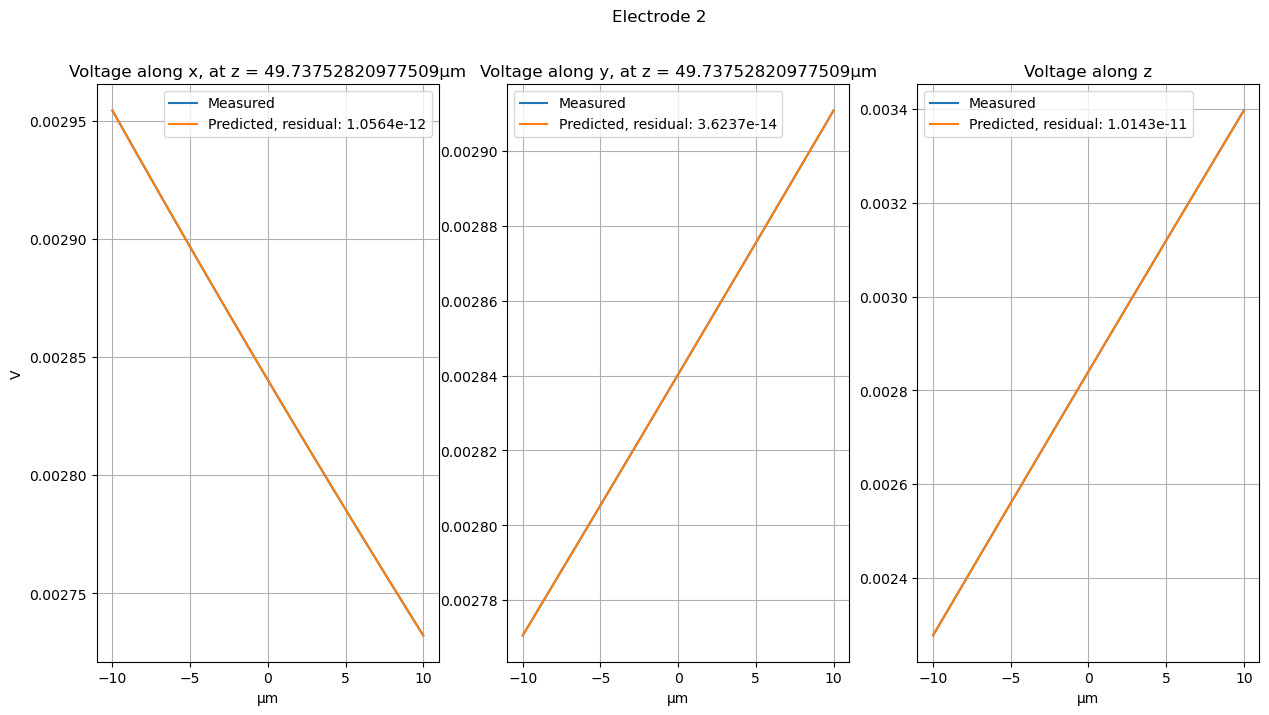

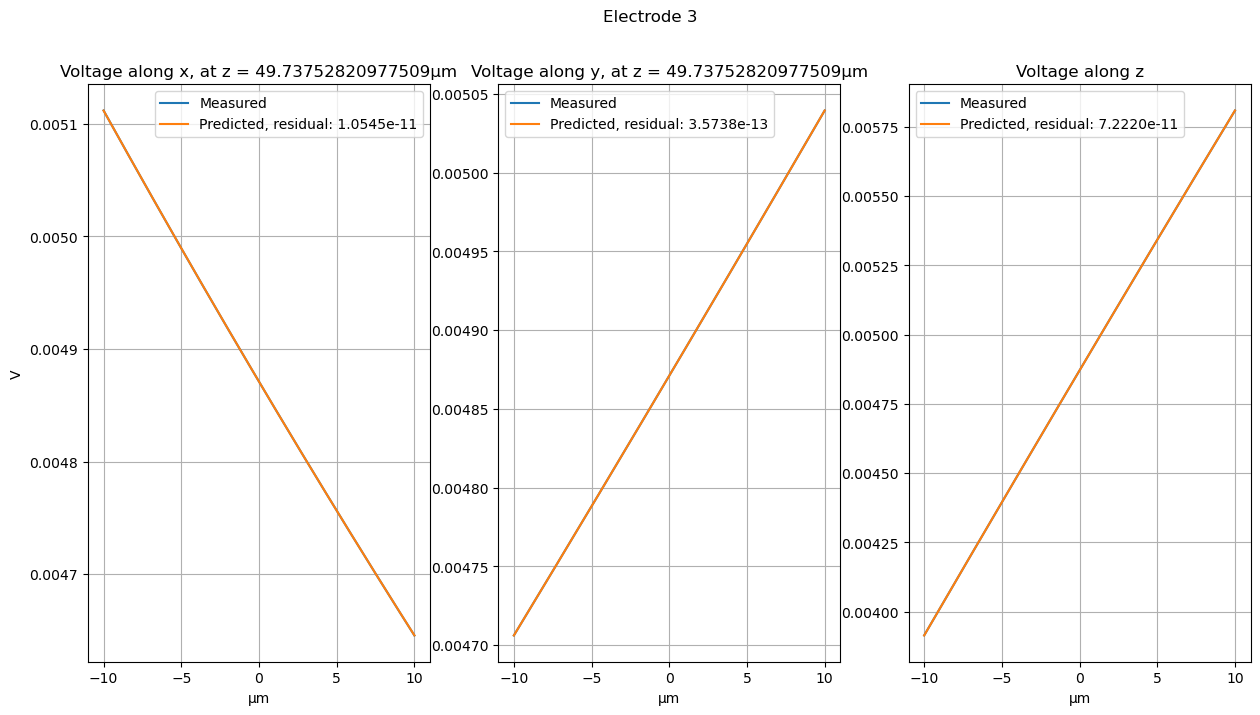

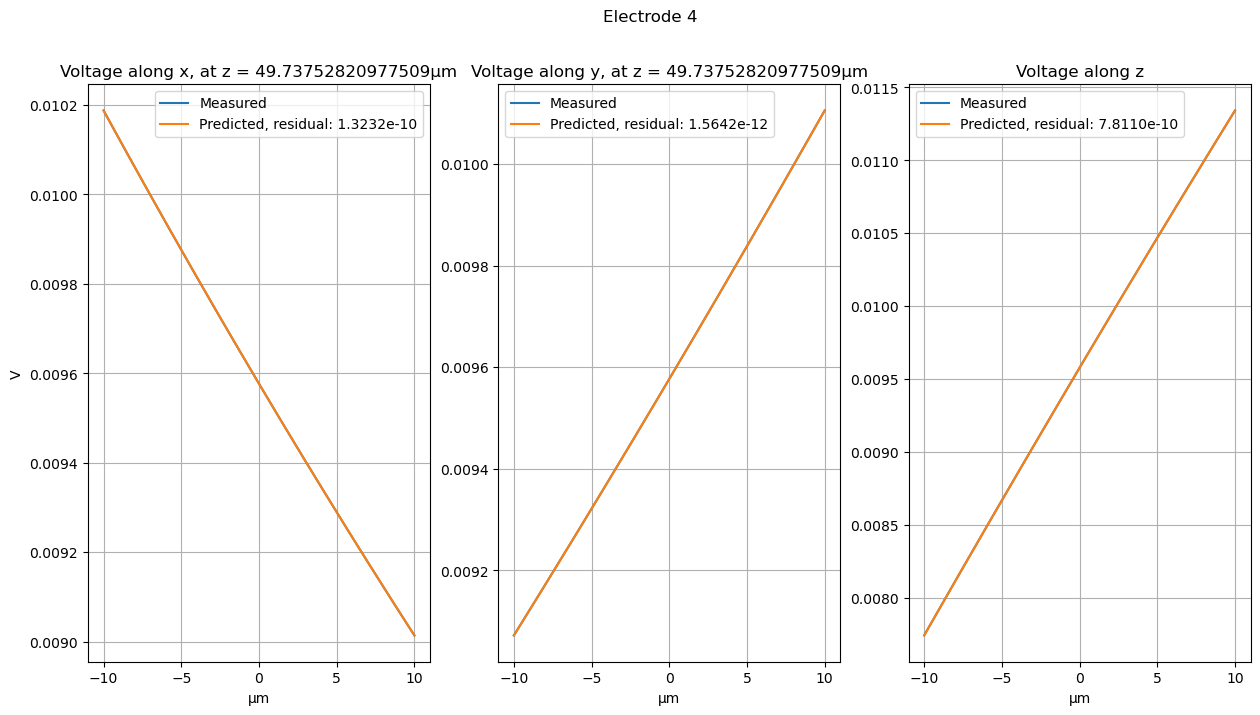

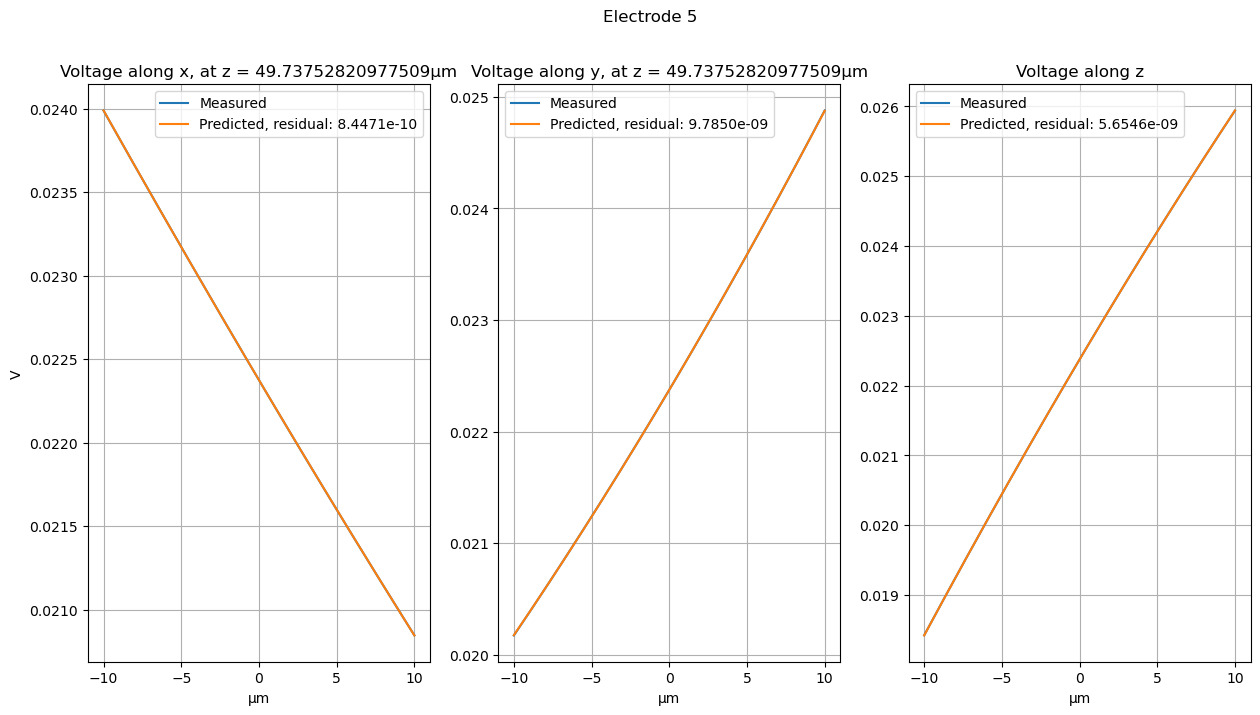

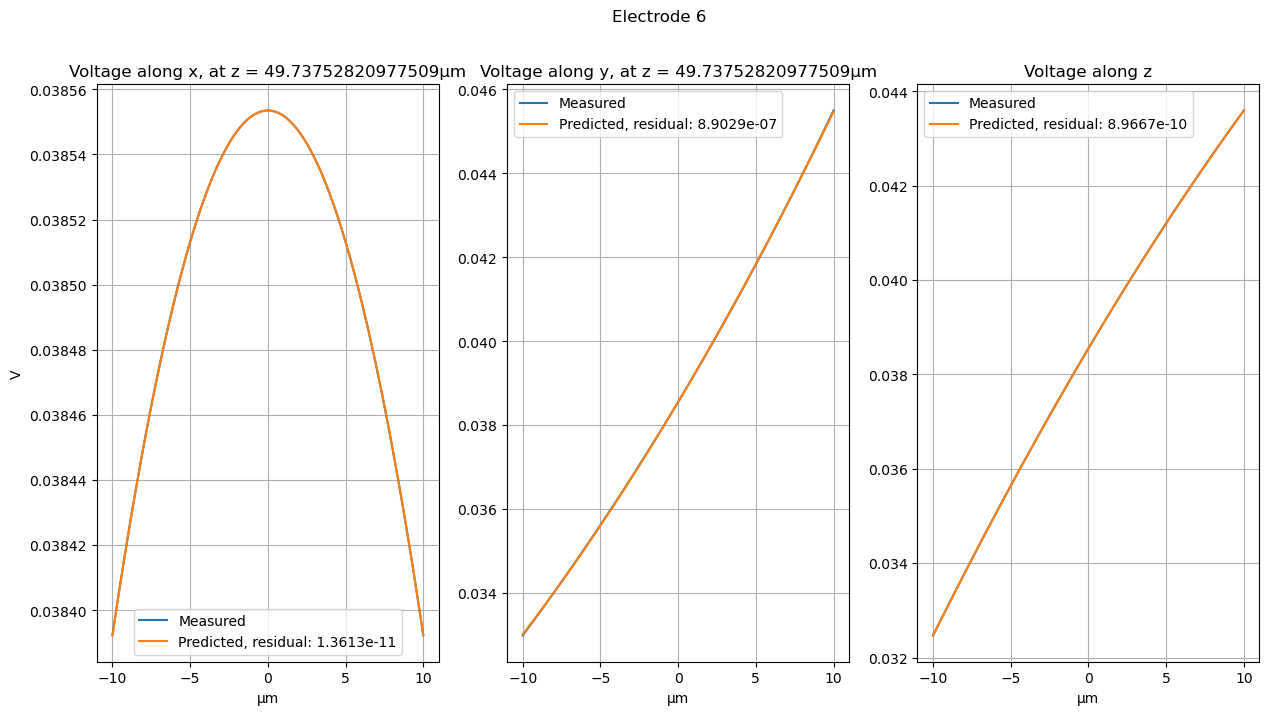

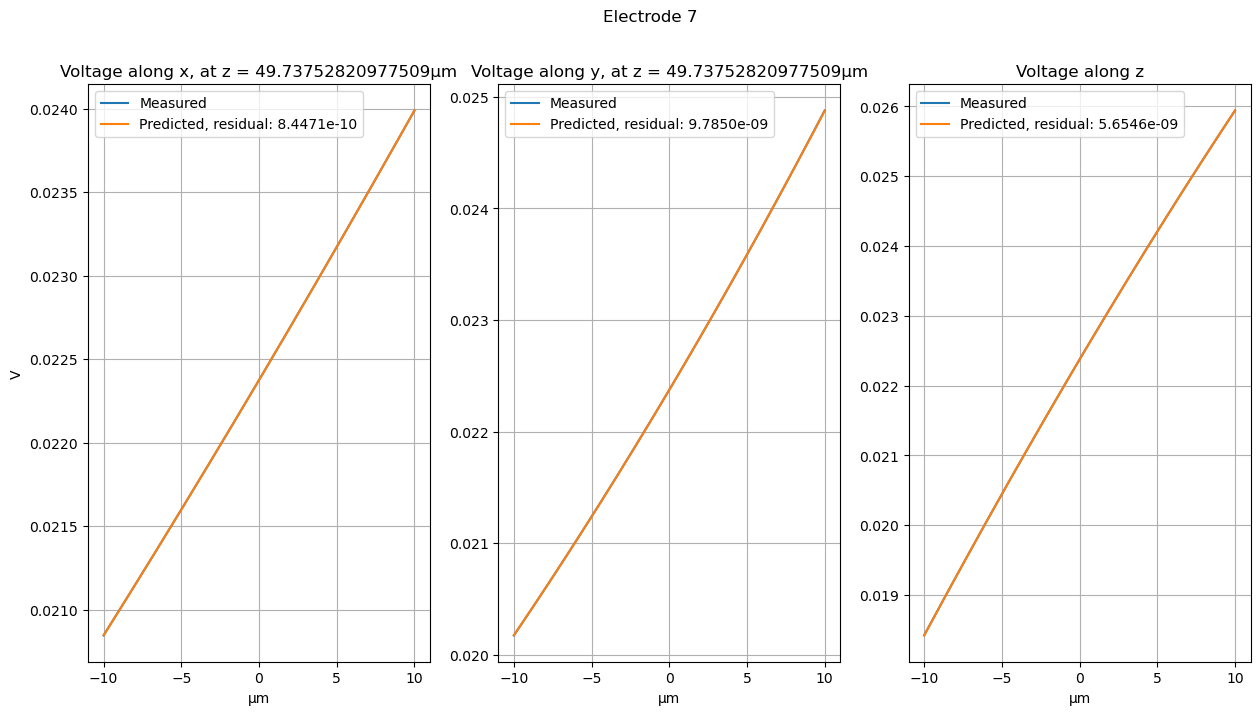

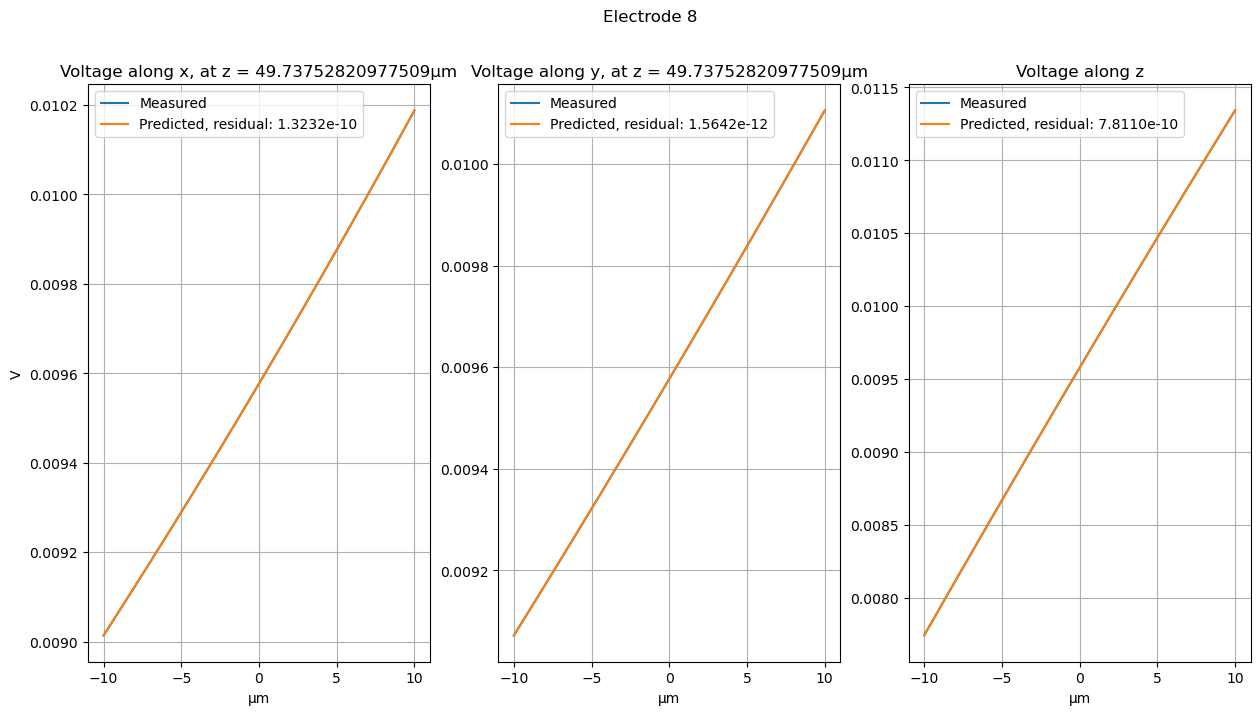

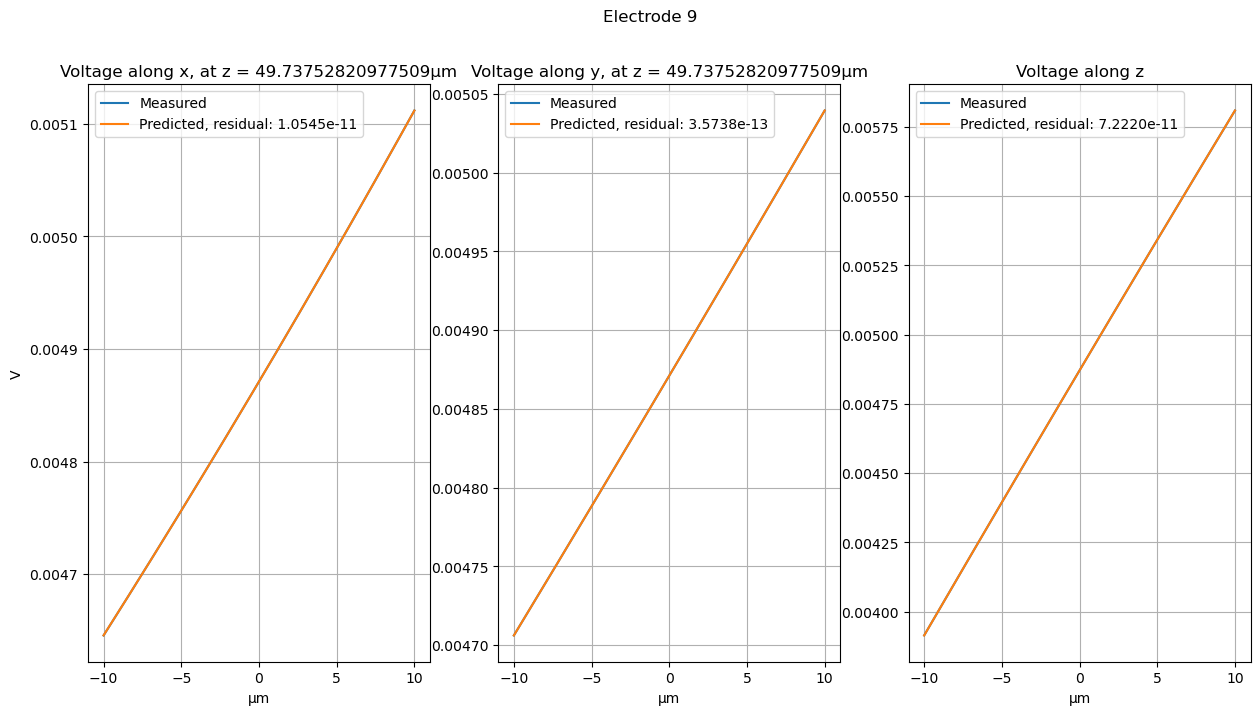

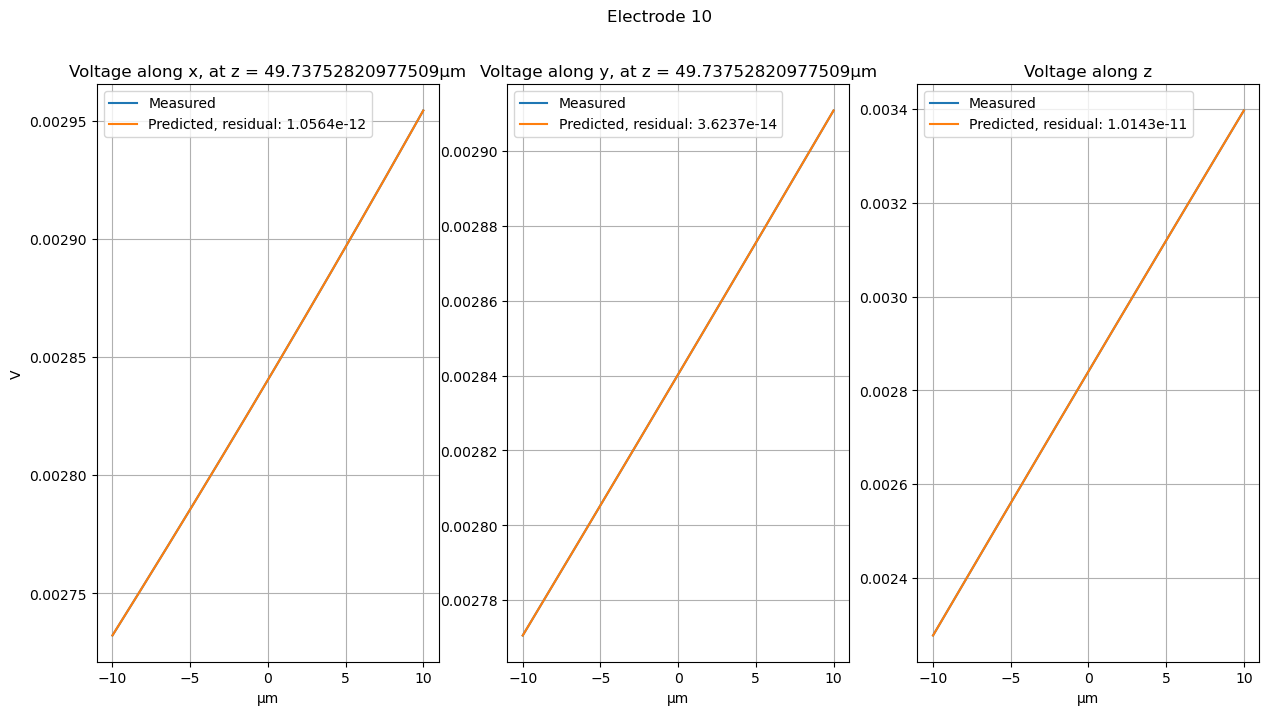

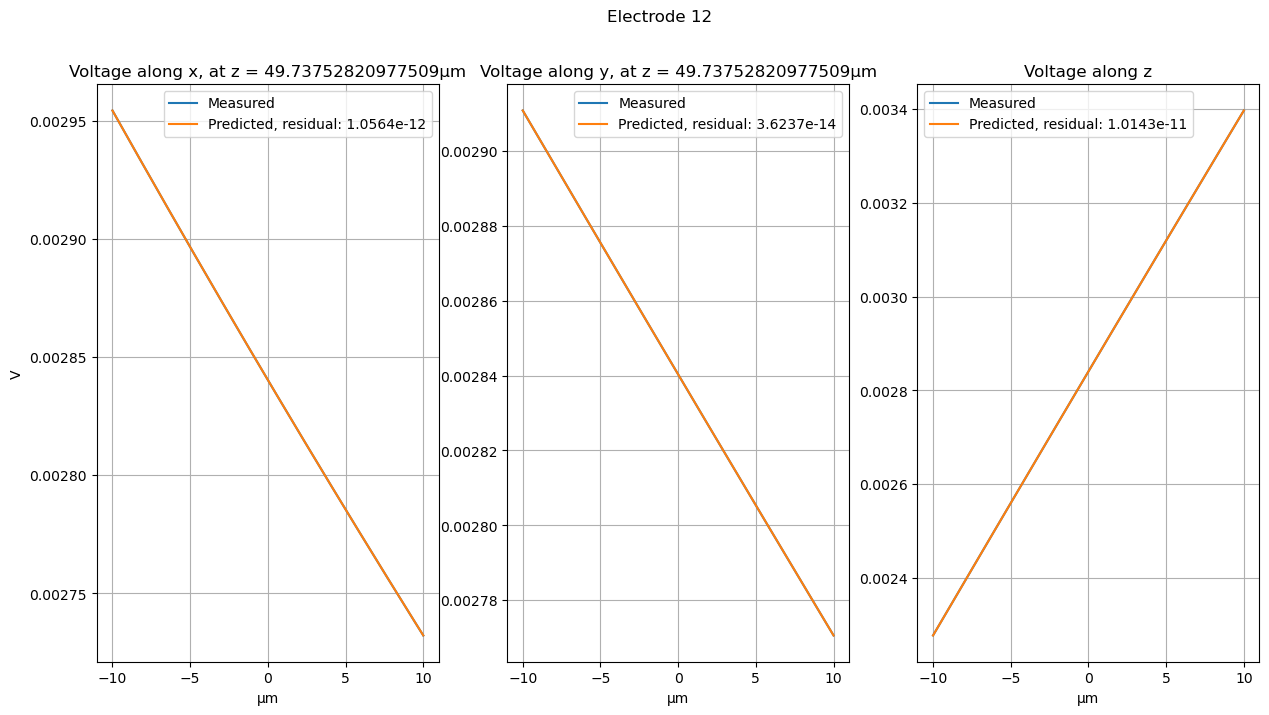

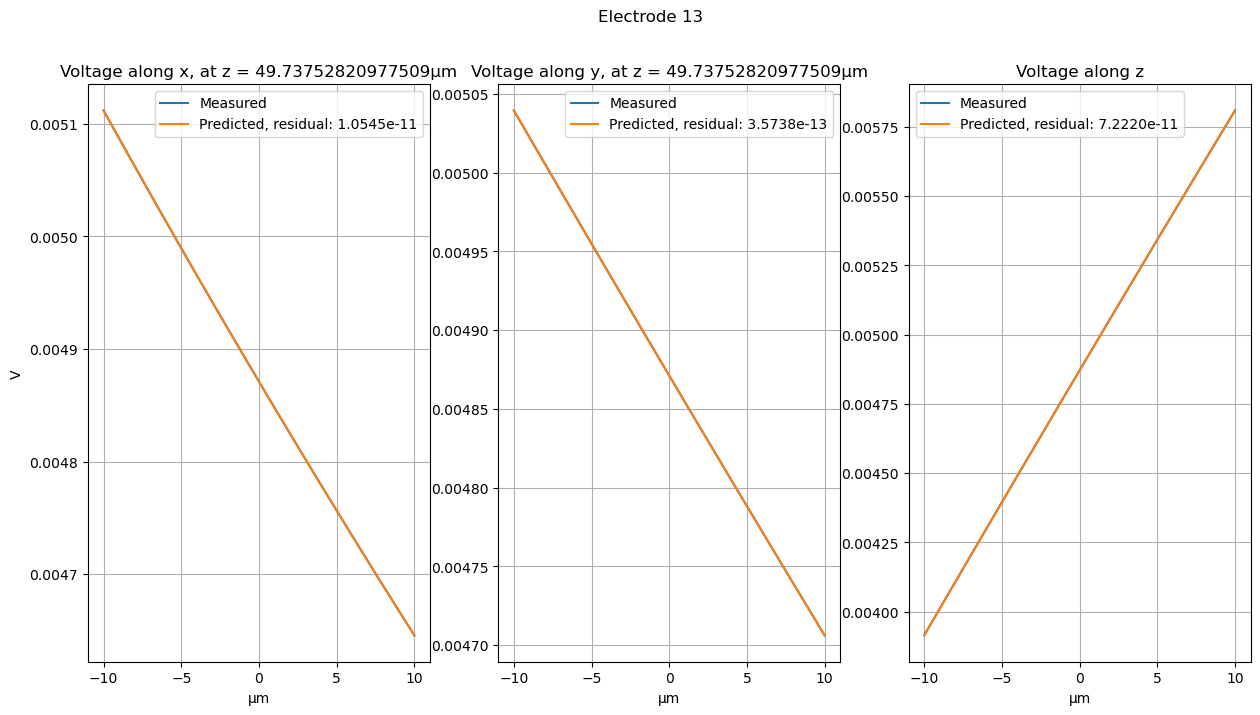

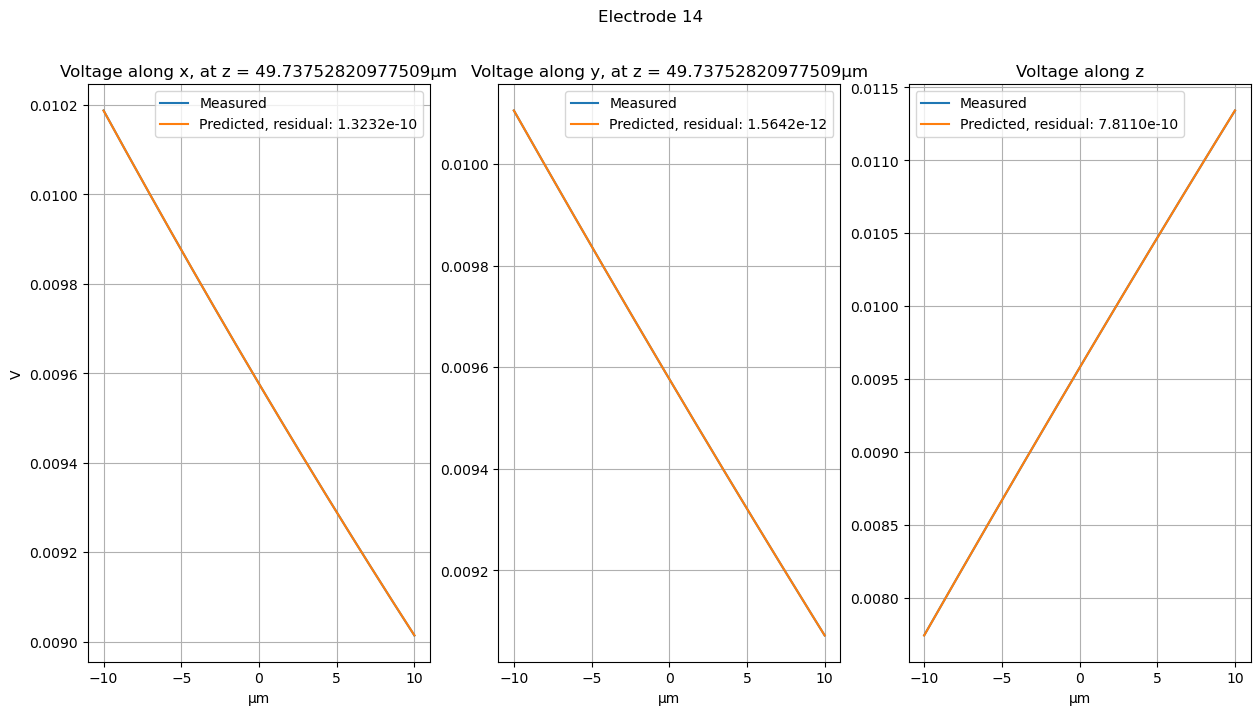

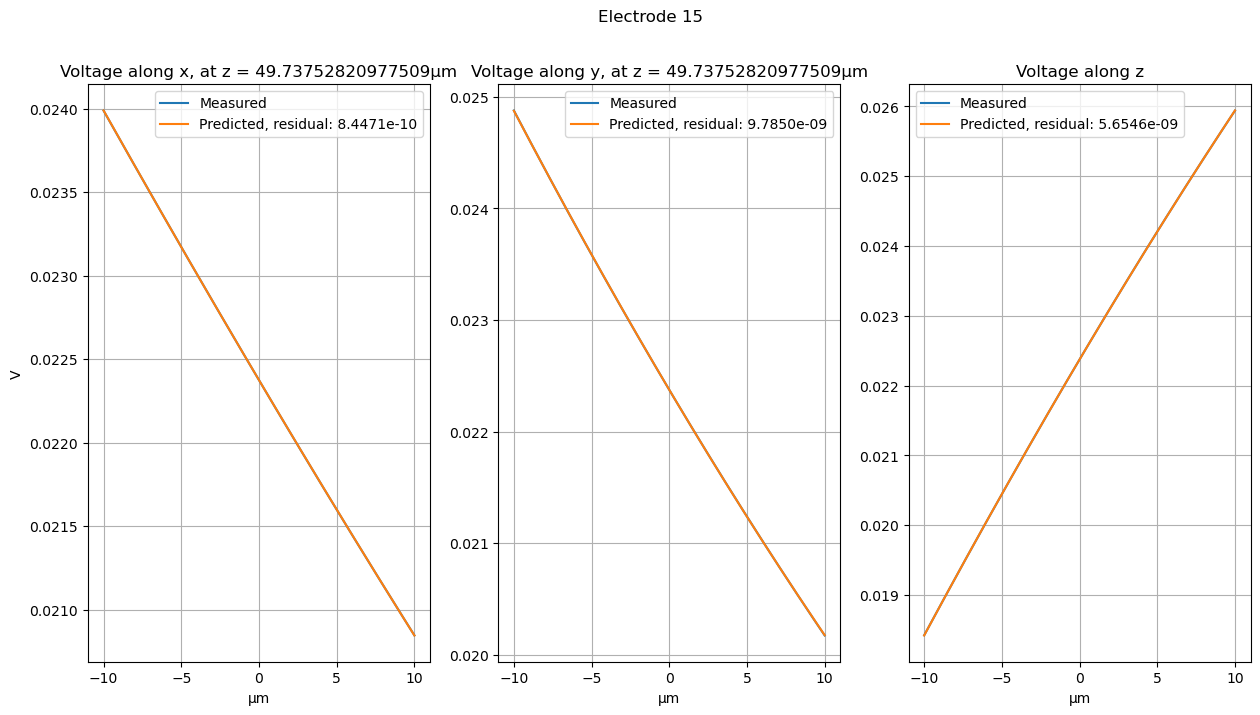

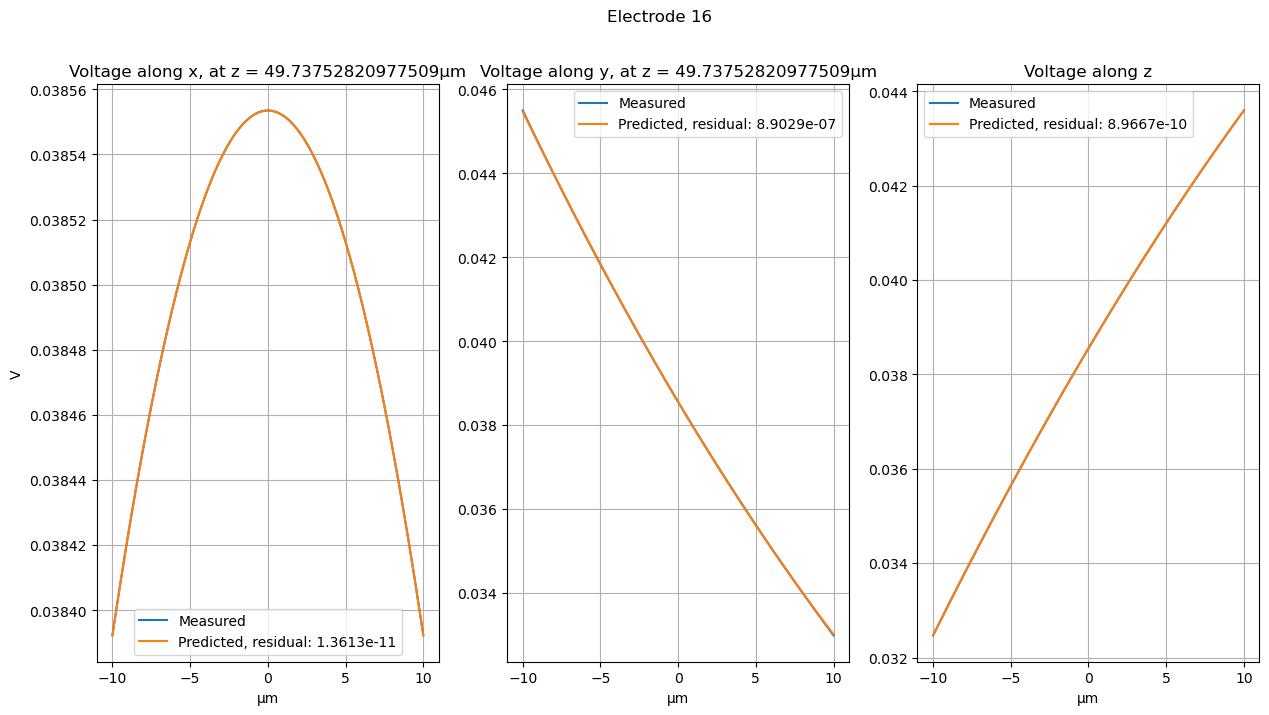

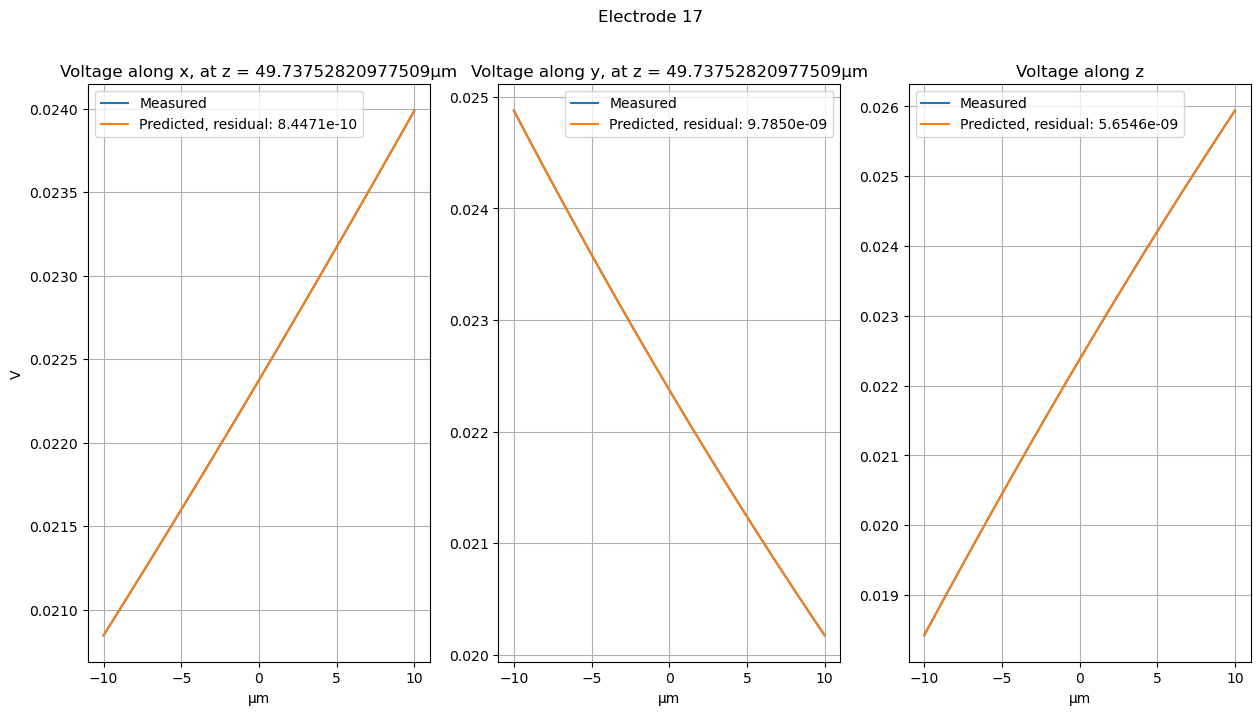

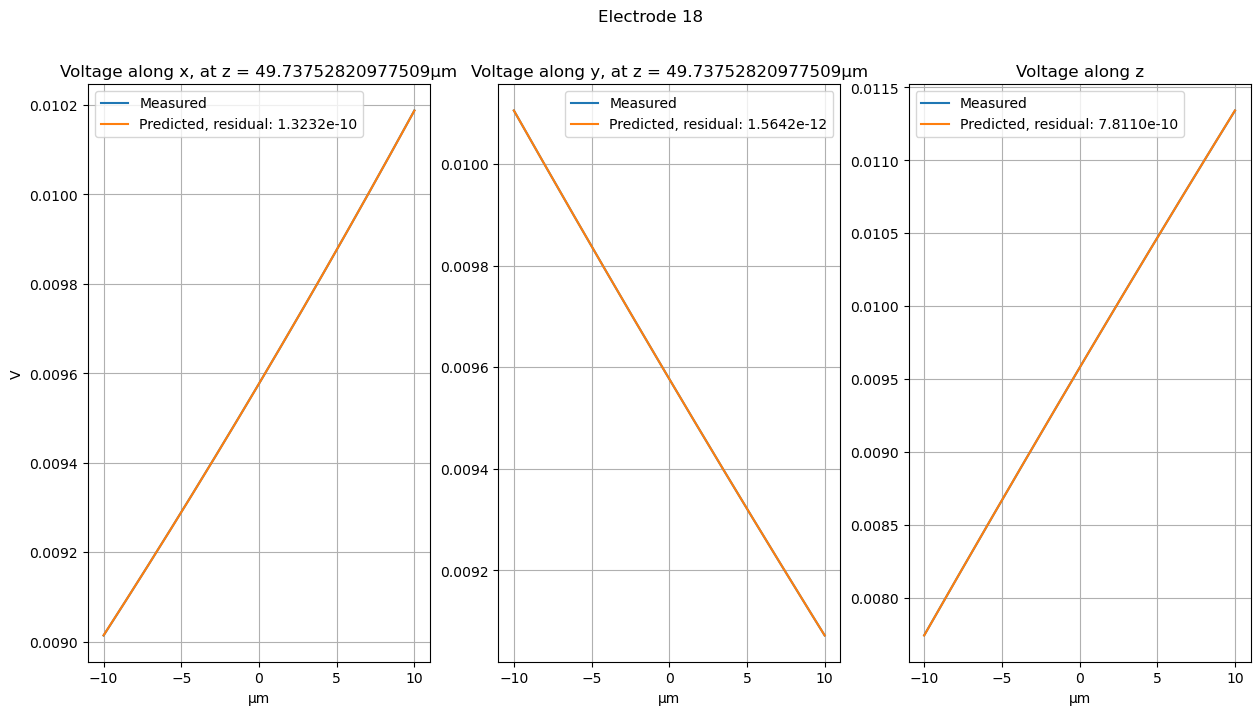

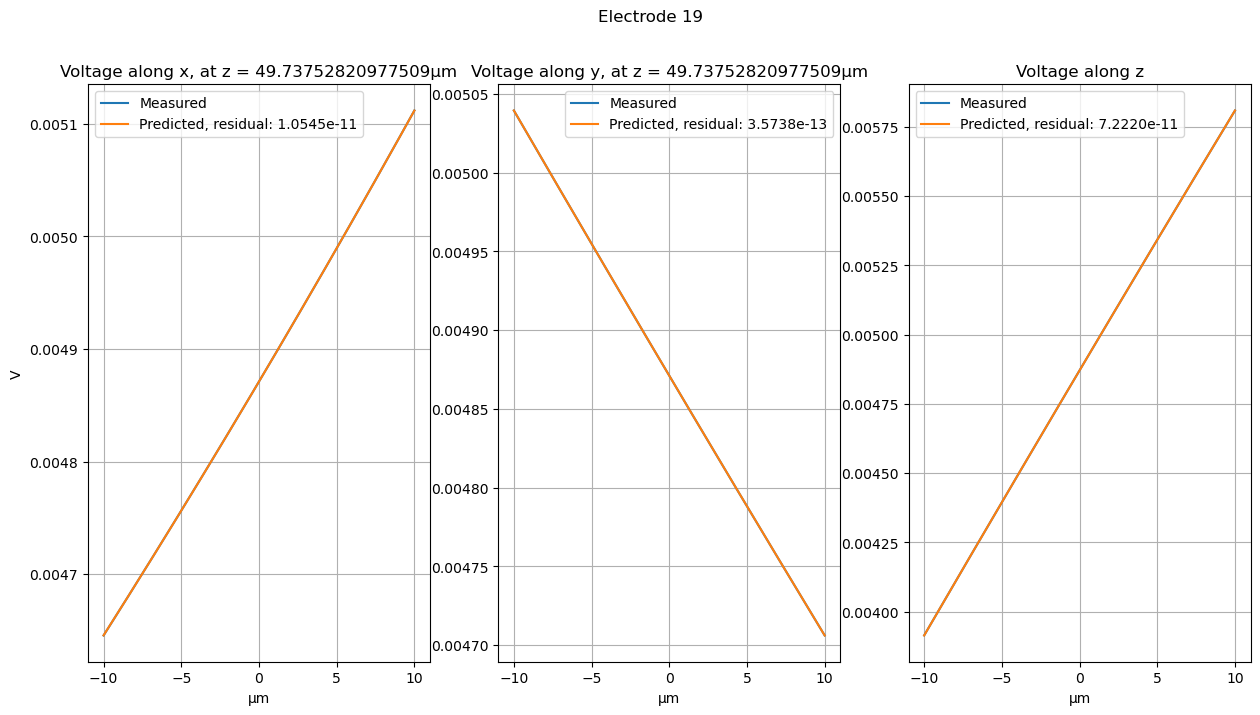

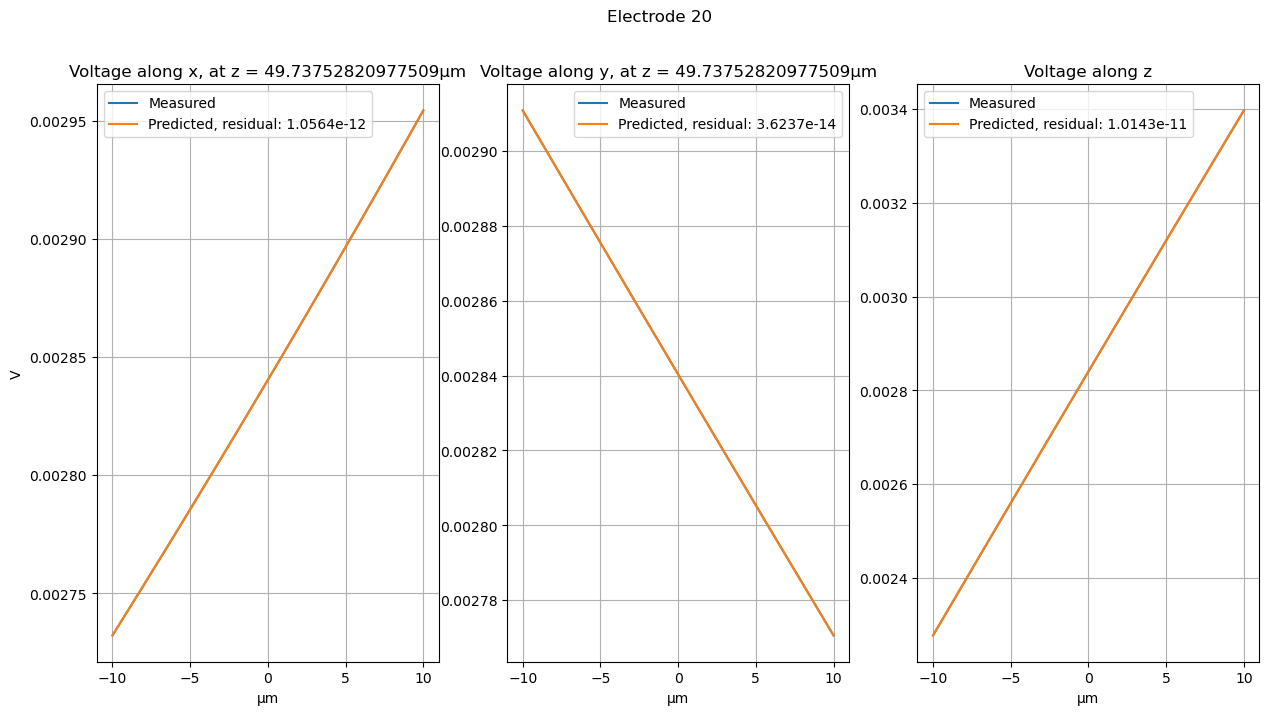

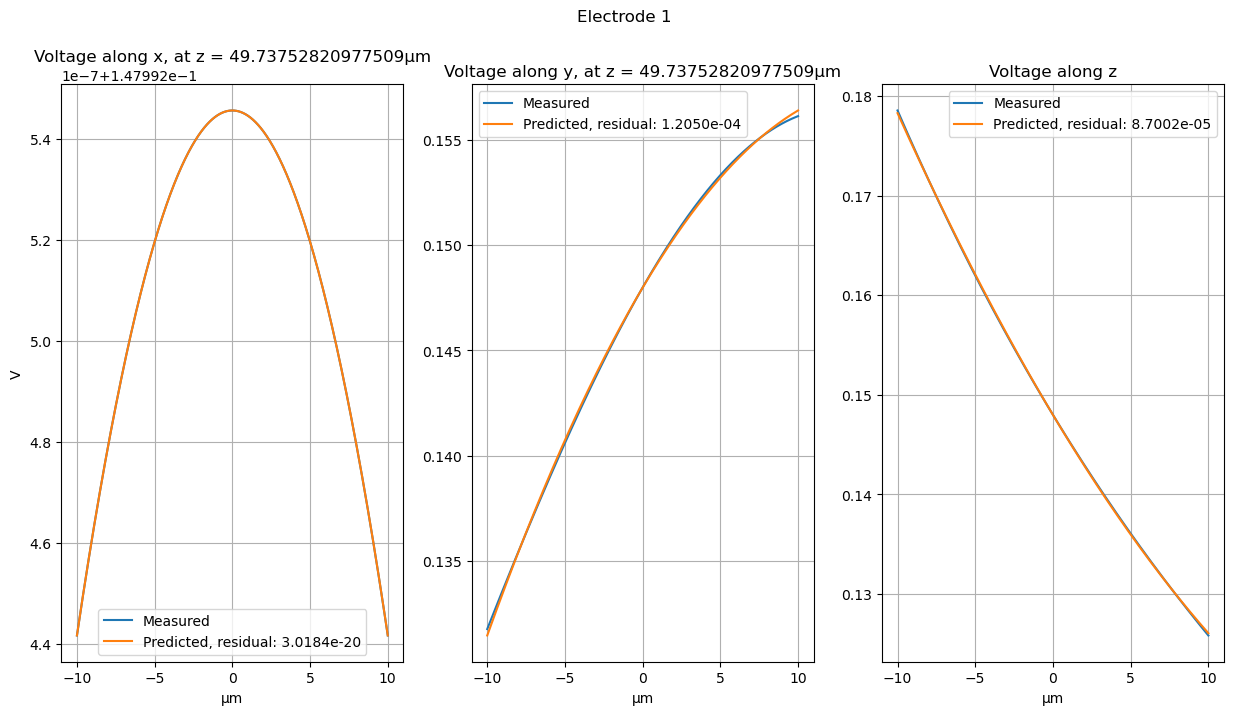

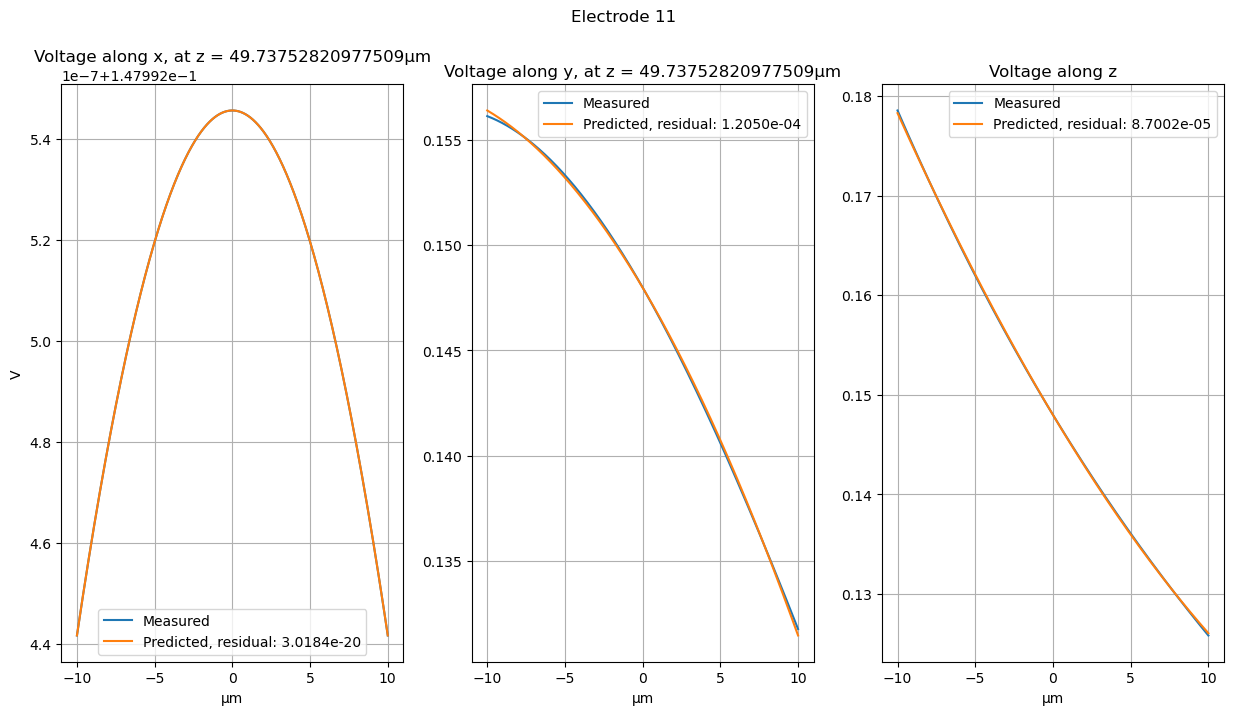

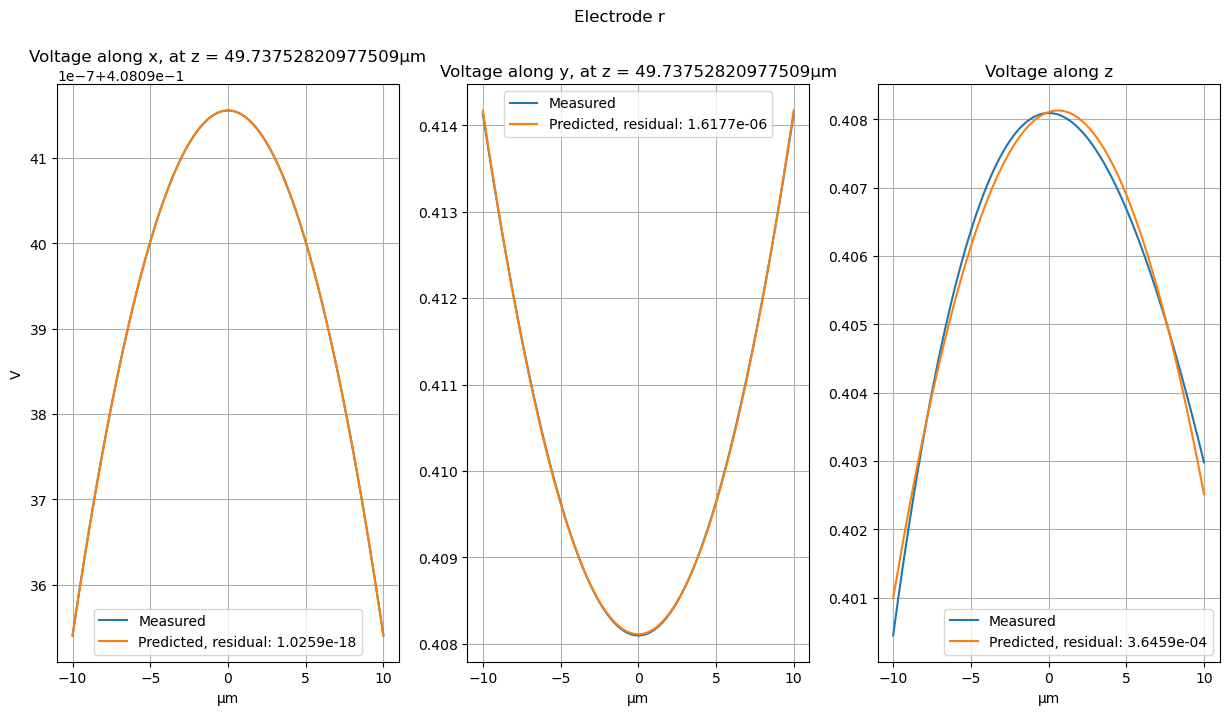

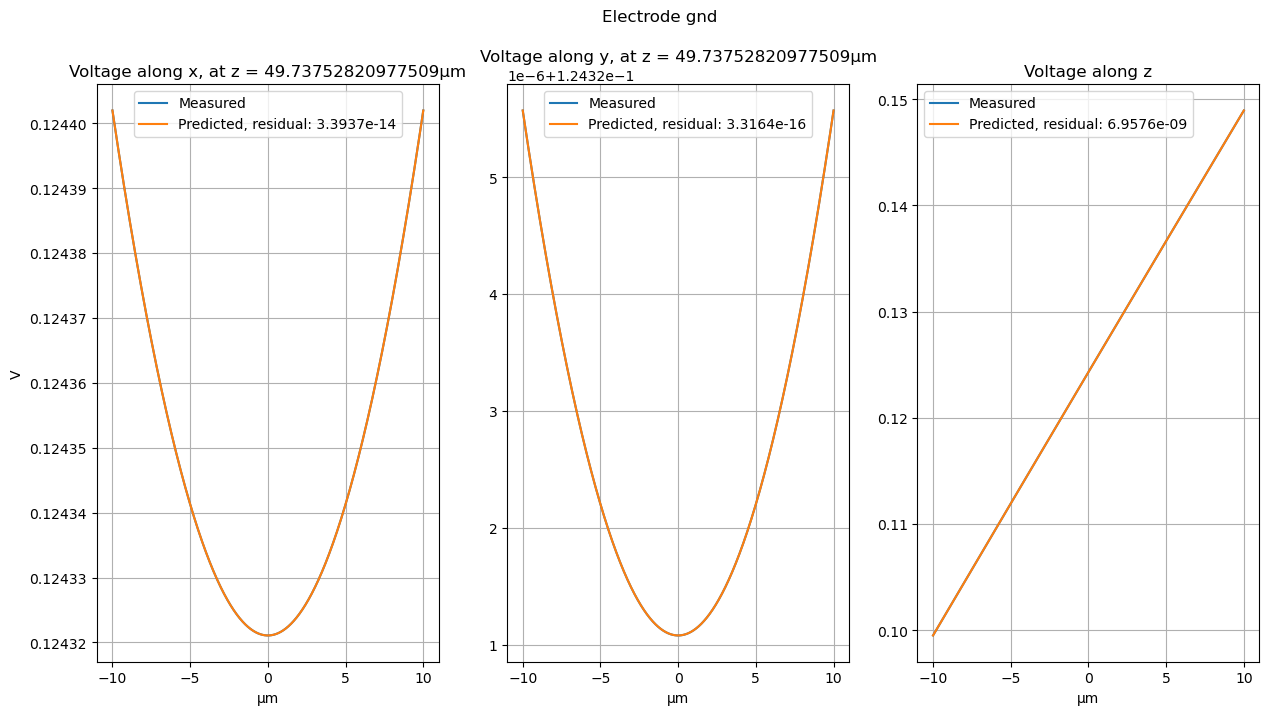

In [114]:
overall_fitted_coeffs = []
overall_residuals = []
do_plot = True
z_new = z
axes = {'x': x, 'y': y, 'z': z}
fit_order = 2
for electrode_num in range(len(s.names)):
    electrode_coeffs = []
    electrode_residuals = []
    # measured = {'x': p_x[electrode_num].flatten(), 'y': p_y[electrode_num].flatten()}
    measured = {'x': p_x[electrode_num].flatten(), 'y': p_y[electrode_num].flatten(), 'z': p_z[electrode_num].flatten()}
    num_axes = len(axes)
    if (do_plot):
        fig_width = 15
        fig, ax = plt.subplots(1, num_axes, figsize=(fig_width, 1/2*fig_width))
        ax = ax.flat
        ax[0].set_ylabel('V')
        electrode_name = s.names[electrode_num]
        fig.suptitle(f'Electrode {electrode_name}')
    for i in range(num_axes):
        ax_name = list(axes.keys())[i]
        ax_coord = list(axes.values())[i]
        # z_height = z_h
        # ax_coord = list(axes.values())[i][:,i]
        # z_height = 0.5*(list(axes.values())[i][:,2][0] + list(axes.values())[i][:,2][-1])
        # fit
        c_arr, A, residual = solve_axes_coeffs(ax_coord, measured[ax_name], order=fit_order)
        residual_str = np.format_float_scientific(residual, unique=False, precision=4)
        electrode_coeffs.append(c_arr)
        electrode_residuals.append(residual)
        # get predicted result
        predicted = np.dot(A, np.array(c_arr).T)
        if (do_plot):
            # plot numerical solution
            ax[i].set_xlabel('µm')
            if(i == 2):
                ax[i].set_title(f'Voltage along {ax_name}')
            else:
                 ax[i].set_title(f'Voltage along {ax_name}, at z = {z_h}µm')
            ax[i].plot(ax_coord, measured[ax_name], label='Measured')
            # plot predicted fit
            ax[i].plot(ax_coord, predicted, label=f'Predicted, residual: {residual_str}')
            ax[i].grid()
            ax[i].legend()
    overall_fitted_coeffs.append(np.array(electrode_coeffs).flatten())
    overall_residuals.append(np.array(electrode_residuals))

# generate columns
columns = ['id']
for i in axes:
    for j in range(fit_order+1):
        columns.append('c_'+str(i)+str(j))
for i in axes:
    columns.append('residuals_' + str(i))
# generate pandas csv file
# print(overall_residuals)
savefile = np.concatenate((np.array([s.names]).T, np.array(overall_fitted_coeffs), np.array(overall_residuals)), axis=1)
df = pd.DataFrame(savefile, columns=columns)
df.to_csv('test_'+ str(datetime.now()) + '_coefficients_quetzal_test_small.csv')
print(columns)


# print(a)

In [115]:

A = np.array(overall_fitted_coeffs)
# remove constant terms from matrix
A = np.delete(A, [0, 3, 6], 1)
# remove rf and gnd electrodes
A = np.delete(A, [-1, -2], 0)
b = np.array([0, 2e-6, 0,-1e-6,0,-1e-6])

A_grouped = []
groups = [['1', '11'], ['4', '14'], ['6', '16'], ['8', '18'], ['5', '7'], ['15', '17']]
groups = [['1', '11'], ['4', '14'], ['6', '16'], ['8', '18'], ['5', '7'], ['15', '17']]
for group in groups:
    group_coeffs = np.zeros(6)
    for electrode_name in group:
        group_coeffs += np.array(A[s.names.index(electrode_name)])
    A_grouped.append(group_coeffs)
A_grouped = np.array(A_grouped)
A_grouped[np.abs(A_grouped)<1e-17] = 0
print(A_grouped)
soln2 = np.linalg.solve(A_grouped.T, b)
print(soln2)

[[ 0.00000000e+00 -2.07843612e-09  0.00000000e+00 -8.10826587e-05
  -5.21993141e-03  8.38055001e-05]
 [-1.17342615e-04  4.79856062e-07  0.00000000e+00  2.35719025e-07
   3.60012142e-04 -7.14260818e-07]
 [ 0.00000000e+00 -3.22372853e-06  0.00000000e+00  1.38008299e-05
   1.11264036e-03 -1.04361246e-05]
 [ 1.17342615e-04  4.79856062e-07  0.00000000e+00  2.35719025e-07
   3.60012142e-04 -7.14260818e-07]
 [ 0.00000000e+00  8.55800161e-07  4.69969412e-04  3.02560347e-06
   7.52054061e-04 -3.86914337e-06]
 [ 0.00000000e+00  8.55800161e-07 -4.69969412e-04  3.02560347e-06
   7.52054061e-04 -3.86914337e-06]]
[ 0.01520629 -1.81821099 -0.48217794 -1.81821099  1.27984315  1.27984315]


In [172]:
np.matmul(A_grouped.T, soln2)

array([ 0.00000000e+00,  2.00000000e-06,  0.00000000e+00, -1.00000000e-06,
        1.08420217e-19, -1.00000000e-06])

[ 0.          0.         -1.81821099  1.27984315 -0.48217794  1.27984315
 -1.81821099  0.          0.          0.          0.         -1.81821099
  1.27984315 -0.48217794  1.27984315 -1.81821099  0.          0.
  0.01520629  0.01520629  0.          0.        ]
[-10.     -9.998  -9.996 ...   9.996   9.998  10.   ]


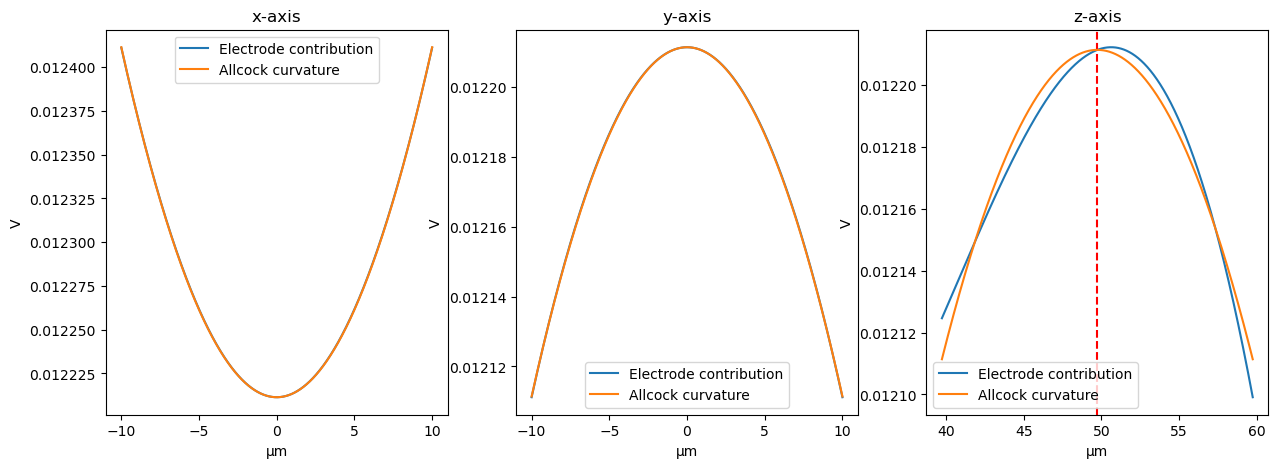

In [116]:
electrode_voltages = np.zeros(len(s.names))
for i in range(len(groups)):
    for electrode_name in groups[i]:
        electrode_voltages[s.names.index(electrode_name)] = soln2[i]
print(electrode_voltages)
tmp_len = 20
x3d, x = single_axis('x', (-tmp_len/2,tmp_len/2), res)
y3d, y = single_axis('y', (-tmp_len/2,tmp_len/2), res)
z3d, z = single_axis('z', (-tmp_len/2,tmp_len/2), res)

with s.with_voltages(electrode_voltages):
    vx = s.electrical_potential(x3d).T
    vy = s.electrical_potential(y3d).T
    vz = s.electrical_potential(z3d).T
    # print(vx)
    # print(x.shape)
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax = ax.flat
    ax[0].plot(x, vx[0], label='Electrode contribution')
    ax[0].plot(x, b[1] * x**2 +vx[0][int((vx.size+1)/2)], label='Allcock curvature')
    ax[0].set_title('x-axis')
    ax[1].plot(y, vy[0], label='Electrode contribution')
    ax[1].plot(y, b[3] * y**2 +vy[0][int((vy.size+1)/2)], label='Allcock curvature')
    ax[1].set_title('y-axis')
    ax[2].plot(z+z_h, vz[0], label='Electrode contribution')
    ax[2].set_title('z-axis')
    ax[2].axvline(x=z_h, linestyle='--', color='r')
    ax[2].plot(z+z_h, b[-1] * z**2 +vz[0][int((vz.size+1)/2)], label='Allcock curvature')
    for i in range(3):
        ax[i].set_xlabel('µm')
        ax[i].set_ylabel('V')
        ax[i].legend()

print(z)

[ 0.          0.         -1.8181931   1.2798354  -0.48217713  1.2798354
 -1.8181931   0.          0.          0.          0.         -1.8181931
  1.2798354  -0.48217713  1.2798354  -1.8181931   0.          0.
  0.01520652  0.01520652  0.          0.        ]
[[-1.19394885e-06 -1.20064193e-06 -1.20737644e-06 ... -1.20737644e-06
  -1.20064193e-06 -1.19394885e-06]
 [ 1.11856185e-23 -1.01963238e-23 -1.59975943e-24 ...  1.32348898e-23
   0.00000000e+00  0.00000000e+00]
 [-1.50299600e-07 -1.51779090e-07 -1.53259742e-07 ...  1.53259742e-07
   1.51779090e-07  1.50299600e-07]
 [ 3.83221916e-07  3.85209851e-07  3.87210471e-07 ...  3.87210471e-07
   3.85209851e-07  3.83221916e-07]
 [-2.11758237e-22 -3.59989003e-21 -8.47032947e-22 ...  2.54109884e-21
  -1.27054942e-21  2.11758237e-22]]
(10001,)
[-1000.   -999.8  -999.6 ...   999.6   999.8  1000. ]


IndexError: index 25003 is out of bounds for axis 0 with size 10001

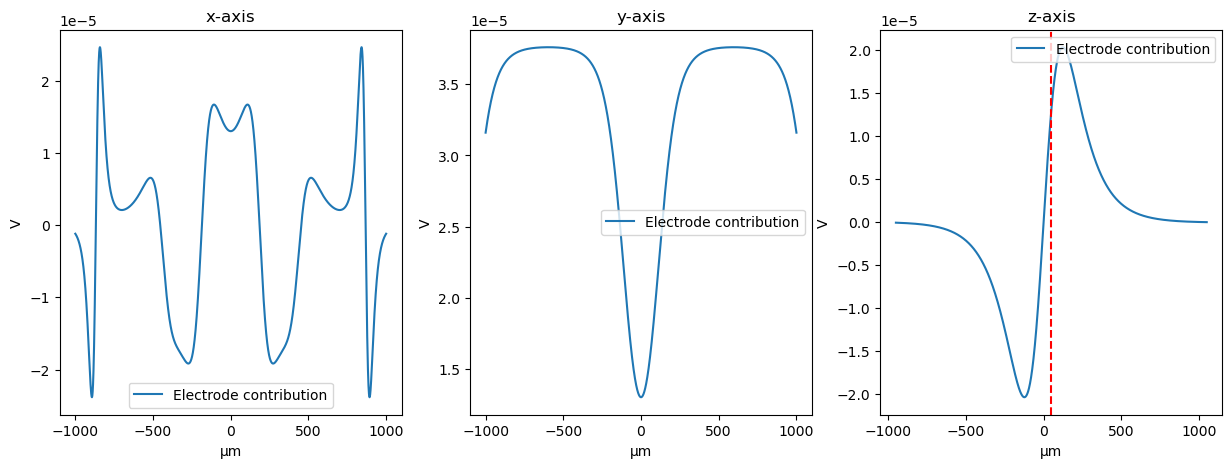

In [102]:
electrode_voltages = np.zeros(len(s.names))
for i in range(len(groups)):
    for electrode_name in groups[i]:
        electrode_voltages[s.names.index(electrode_name)] = soln2[i]
print(electrode_voltages)
tmp_len = 2000
x3d, x = single_axis('x', (-tmp_len/2,tmp_len/2), res)
y3d, y = single_axis('y', (-tmp_len/2,tmp_len/2), res)
z3d, z = single_axis('z', (-tmp_len/2,tmp_len/2), res)

#2019 vs2 transposed to center
electrode_voltages = np.array([
    0, 2.6378, 2.6378, -2.0898, -2.0898, -2.0898, 2.6378, 2.6378, 0, 0, 2.6378, 2.6378, -2.0898, -2.0898, -2.0898, 2.6378, 2.6378, 0, -0.50453, -0.50453, 0, 0
])
# electrode_voltages = np.array([
#     2.6378, 2.6378, -2.0898, -2.0898, -2.0898, 2.6378, 2.6378, 0, 0, 2.6378, 2.6378, -2.0898, -2.0898, -2.0898, 2.6378, 2.6378, 0, 0, -0.50453, -0.50453, 0, 0
# ])

with s.with_voltages(electrode_voltages):
    # vx = s.electrical_potential(x3d).T
    # vy = s.electrical_potential(y3d).T
    # vz = s.electrical_potential(z3d).T
    vx = s.electrical_potential(x3d, derivative=2).T
    vy = s.electrical_potential(y3d, derivative=2).T
    vz = s.electrical_potential(z3d, derivative=2).T
    print(vx)
    print(x.shape)
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax = ax.flat
    ax[0].plot(x, vx[0], label='Electrode contribution')
    # ax[0].plot(x, b[1] * x**2 +vx[0][int((vx.size+1)/2)], label='Allcock curvature')
    ax[0].set_title('x-axis')
    ax[1].plot(y, vy[0], label='Electrode contribution')
    # ax[1].plot(y, b[3] * y**2 +vy[0][int((vy.size+1)/2)], label='Allcock curvature')
    ax[1].set_title('y-axis')
    ax[2].plot(z+50, vz[0], label='Electrode contribution')
    ax[2].set_title('z-axis')
    ax[2].axvline(x=z_h, linestyle='--', color='r')
    # ax[2].plot(z+z_h, b[-1] * z**2 +vz[0][int((vz.size+1)/2)], label='Allcock curvature')
    for i in range(3):
        ax[i].set_xlabel('µm')
        ax[i].set_ylabel('V')
        ax[i].legend()

print(z)

laplace = vx[0][int((vx.size+1)/2)] + vy[0][int((vy.size+1)/2)] + vz[0][int((vz.size+1)/2)]
print(laplace)

[[-0.14907142 -0.14909685 -0.14912178 -0.1491462  -0.14917011 -0.14919352
  -0.14921641 -0.1492388  -0.14926067 -0.14928204 -0.1493029  -0.14932325
  -0.14934308 -0.14936241 -0.14938122 -0.14939952 -0.14941731 -0.14943459
  -0.14945136 -0.14946761 -0.14948335 -0.14949857 -0.14951329 -0.14952748
  -0.14954117 -0.14955434 -0.14956699 -0.14957913 -0.14959075 -0.14960186
  -0.14961246 -0.14962253 -0.1496321  -0.14964114 -0.14964967 -0.14965769
  -0.14966518 -0.14967217 -0.14967863 -0.14968458 -0.14969001 -0.14969492
  -0.14969932 -0.1497032  -0.14970656 -0.14970941 -0.14971173 -0.14971354
  -0.14971484 -0.14971561 -0.14971587 -0.14971561 -0.14971484 -0.14971354
  -0.14971173 -0.14970941 -0.14970656 -0.1497032  -0.14969932 -0.14969492
  -0.14969001 -0.14968458 -0.14967863 -0.14967217 -0.14966518 -0.14965769
  -0.14964967 -0.14964114 -0.1496321  -0.14962253 -0.14961246 -0.14960186
  -0.14959075 -0.14957913 -0.14956699 -0.14955434 -0.14954117 -0.14952748
  -0.14951329 -0.14949857 -0.14948335 

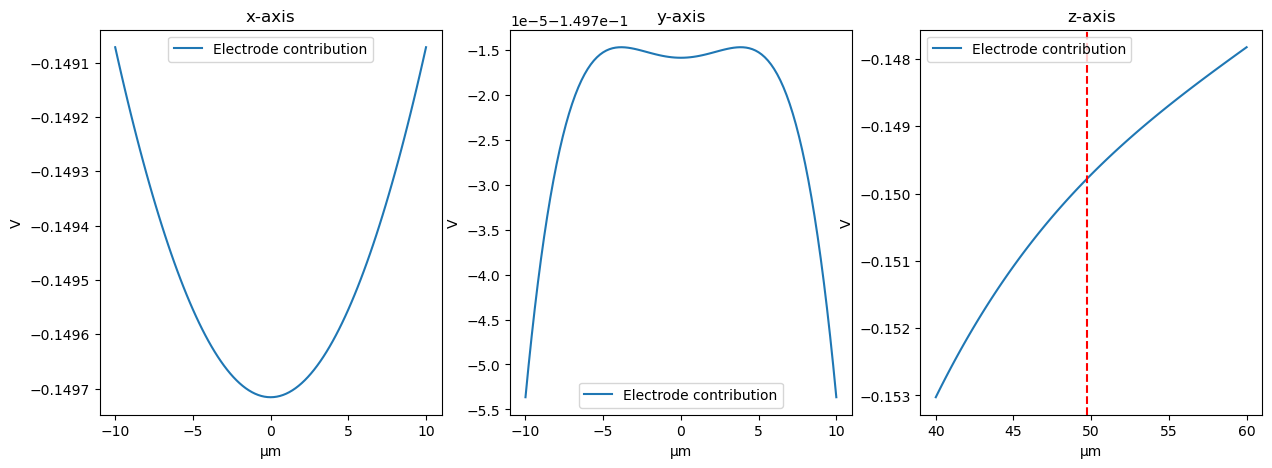

In [16]:
# electrode_voltages = np.zeros(len(s.names))
# for i in range(len(groups)):
#     # group_coeffs = np.zeros(len(b))
#     for electrode_name in groups[i]:
#         electrode_voltages[s.names.index(electrode_name)] = soln2[i]
# print(electrode_voltages)
tmp_len = 20
res = 101
x3d, x = single_axis('x', (-tmp_len/2,tmp_len/2), res)
y3d, y = single_axis('y', (-tmp_len/2,tmp_len/2), res)
z3d, z = single_axis('z', (-tmp_len/2,tmp_len/2), res)

#2019 vs2 transposed to center
# electrode_voltages = np.array([
#     0, 2.6378, 2.6378, -2.0898, -2.0898, -2.0898, 2.6378, 2.6378, 0, 0, 2.6378, 2.6378, -2.0898, -2.0898, -2.0898, 2.6378, 2.6378, 0, -0.50453, -0.50453, 0, 0
# ])
# electrode_voltages = np.array([
#     2.6378, 2.6378, -2.0898, -2.0898, -2.0898, 2.6378, 2.6378, 0, 0, 2.6378, 2.6378, -2.0898, -2.0898, -2.0898, 2.6378, 2.6378, 0, 0, -0.50453, -0.50453, 0, 0
# ])
# 2019 v1
electrode_voltages = np.array([
    0, 0, 0, 0.58095, -1.6915, 0.58095, 0, 0, 0, 0, 0, 0, 0.58095, -1.6915, 0.58095, 0, 0, 0, -0.24083, -0.24083, 0, 0
])

b=[2e-6, -1e-6, -1e-6]

with s.with_voltages(electrode_voltages):
    vx = s.electrical_potential(x3d).T
    vy = s.electrical_potential(y3d).T
    vz = s.electrical_potential(z3d).T
    print(vx)
    print(x.shape)
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax = ax.flat
    ax[0].plot(x, vx[0], label='Electrode contribution')
    # ax[0].plot(x, b[1] * x**2 +vx[0][int((vx.size+1)/2)], label='Allcock curvature')
    ax[0].set_title('x-axis')
    ax[1].plot(y, vy[0], label='Electrode contribution')
    # ax[1].plot(y, b[3] * y**2 +vy[0][int((vy.size+1)/2)], label='Allcock curvature')
    ax[1].set_title('y-axis')
    ax[2].plot(z+50, vz[0], label='Electrode contribution')
    ax[2].set_title('z-axis')
    ax[2].axvline(x=z_h, linestyle='--', color='r')
    # ax[2].plot(z+z_h, b[-1] * z**2 +vz[0][int((vz.size+1)/2)], label='Allcock curvature')
    for i in range(3):
        ax[i].set_xlabel('µm')
        ax[i].set_ylabel('V')
        ax[i].legend()

print(z)

In [173]:
def solve_voltages(el_names, fitted_coeffs, b, groups):
    A = np.array(fitted_coeffs)
    # remove constant terms from matrix
    A = np.delete(A, [0, 3, 6], 1)
    # remove rf and gnd electrodes
    A = np.delete(A, [-1, -2], 0)
    b = np.array(b)

    A_grouped = []
    for group in groups:
        group_coeffs = np.zeros(6)
        for electrode_name in group:
            group_coeffs += np.array(A[el_names.index(electrode_name)])
        A_grouped.append(group_coeffs)
    A_grouped = np.array(A_grouped)
    A_grouped[np.abs(A_grouped)<1e-17] = 0

    group_voltages = np.linalg.solve(A_grouped.T, b)
    return group_voltages

1: [4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.

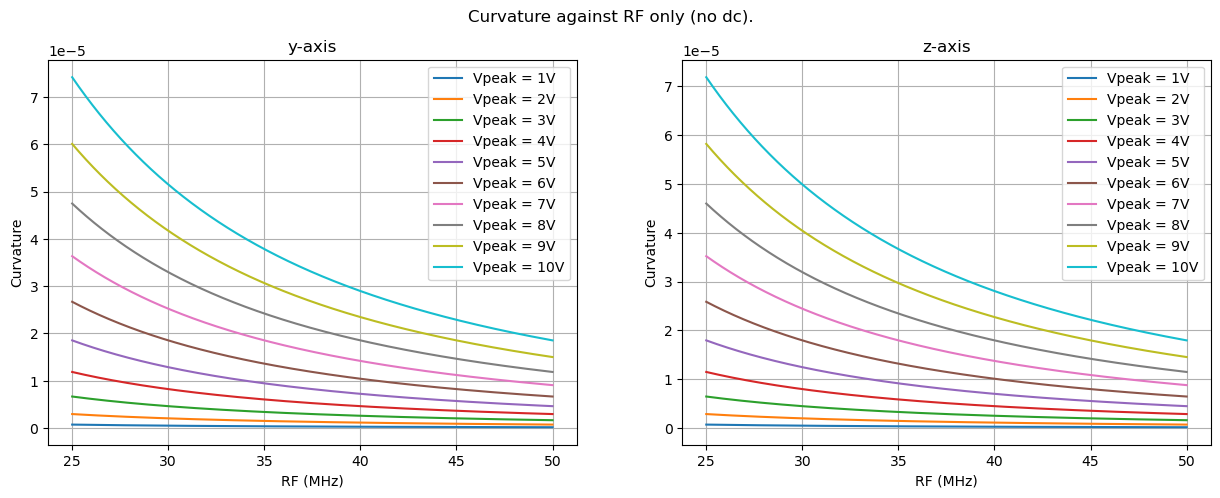

In [245]:
# Plot - curvature against rf frequency, at different u
u_range = np.arange(1, 10+1)
f_range = np.linspace(25e6, 50e6, 1000)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
pp_overall_y = []
derivative = 2
for u in u_range:
    l = 1e-6 # µm length scale
    m = 40*ct.atomic_mass # 40Ca+ ion mass
    q = 1*ct.elementary_charge # ion charge
    o_range = 2*np.pi*f_range
    pp_y = []
    pp_z = []
    for o in o_range:
        s["r"].rf = u*np.sqrt(q/m)/(2*l*o)
        pp = s.pseudo_potential(x0, derivative=derivative)
        pp_y.append(pp[0, 1, 1])
        pp_z.append(pp[0, 2, 2])
    ax[0].plot(f_range/1e6, pp_y, label=f'Vpeak = {u}V')
    ax[0].set_title('y-axis')
    # ax[0].set_xlabel('f (Hz)')
    # ax[0].set_ylabel('Curvature')
    ax[1].plot(f_range/1e6, pp_z, label=f'Vpeak = {u}V')
    ax[1].set_title('z-axis')
    pp_overall_y.append(pp_y)
    
for i in range(2):
    ax[i].set_xlabel('RF (MHz)')
    ax[i].set_ylabel('Curvature')
    ax[i].legend()
    # ax[i].set_yscale('log')
    ax[i].grid()
plt.suptitle('Curvature against RF only (no dc).')

p1 = pp_overall_y[0]
print('1:', np.array(pp_overall_y[1]) / np.array(p1), '2:', np.array(pp_overall_y[2]) / np.array(p1))

In [226]:
s.minimum([0.,0.,52.])

array([ 0.        ,  0.        , 49.71711456])

/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_2966/1768242570.py:18: RuntimeWarning: invalid value encountered in sqrt
  freqs_pp = np.sqrt(q*curves/m)/(2*np.pi*l)
/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_2966/1768242570.py:18: RuntimeWarning: invalid value encountered in sqrt
  freqs_pp = np.sqrt(q*curves/m)/(2*np.pi*l)
/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_2966/1768242570.py:18: RuntimeWarning: invalid value encountered in sqrt
  freqs_pp = np.sqrt(q*curves/m)/(2*np.pi*l)
/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_2966/1768242570.py:18: RuntimeWarning: invalid value encountered in sqrt
  freqs_pp = np.sqrt(q*curves/m)/(2*np.pi*l)
/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_2966/1768242570.py:18: RuntimeWarning: invalid value encountered in sqrt
  freqs_pp = np.sqrt(q*curves/m)/(2*np.pi*l)
/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_2966/1768242570.py:18: RuntimeWarning: invalid value enc

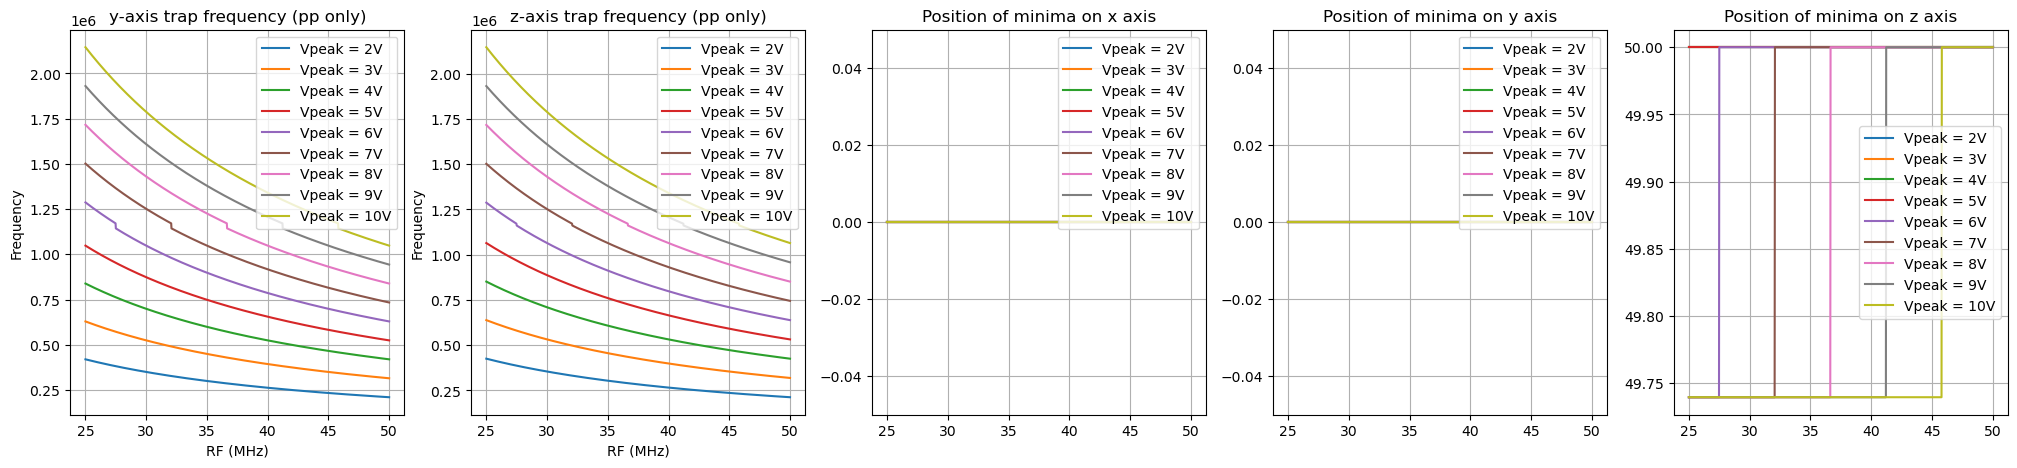

In [238]:
# Plot - pp-frequency against rf frequency, at different u
u_range = np.arange(2, 10+1)
f_range = np.linspace(25e6, 50e6, 1000)
fig, ax = plt.subplots(1, 5, figsize=(25,5))
for u in u_range:
    l = 1e-6 # µm length scale
    m = 40*ct.atomic_mass # 40Ca+ ion mass
    q = 1*ct.elementary_charge # ion charge
    o_range = 2*np.pi*f_range
    x = [0., 0., 50.]
    pf_y = []
    pf_z = []
    x0s = []
    for o in o_range:
        s["r"].rf = u*np.sqrt(q/m)/(2*l*o)
        x0 = s.minimum(x)
        curves, modes_pp = s.modes(x0)
        freqs_pp = np.sqrt(q*curves/m)/(2*np.pi*l)
        pf_y.append(freqs_pp[1])
        pf_z.append(freqs_pp[2])
        x0s.append(x0)
        # print(x0)
        # print(curves, 'modes: ', modes_pp)
        
    ax[0].plot(f_range/1e6, pf_y, label=f'Vpeak = {u}V')
    ax[0].set_title('y-axis trap frequency (pp only)')
    # ax[0].set_xlabel('f (Hz)')
    # ax[0].set_ylabel('Curvature')
    ax[1].plot(f_range/1e6, pf_z, label=f'Vpeak = {u}V')
    ax[1].set_title('z-axis trap frequency (pp only)')

    coord = ['x', 'y', 'z']
    x0s = np.array(x0s)
    # print(x0s)
    for i in range(2, 5):
        ax[i].plot(f_range/1e6, x0s[:, i-2], label=f'Vpeak = {u}V')
        ax[i].set_title(f'Position of minima on {coord[i-2]} axis')
    
for i in range(2):
    ax[i].set_xlabel('RF (MHz)')
    ax[i].set_ylabel('Frequency')
    ax[i].legend()
    # ax[i].set_yscale('log')
    ax[i].grid()
for i in range(2, 5):
    ax[i].legend()
    ax[i].grid()
for i in range(2, 4):
    ax[i].set_ylim(-0.05, 0.05)
# plt.suptitle('Curvature against frequency due to RF only.')


In [342]:
# potential for best-case scenario

In [304]:
print(electrode_voltages.T)
# savefile = np.concatenate((np.array([s.names]).T, np.array(overall_fitted_coeffs), np.array(overall_residuals)), axis=1)
el_df = pd.DataFrame(electrode_voltages.T, columns=["V"])
el_df.to_csv('Vs_'+ str(datetime.today()) + '_axial.csv')


[ 0.          0.         -1.81821099  1.27984315 -0.48217794  1.27984315
 -1.81821099  0.          0.          0.          0.         -1.81821099
  1.27984315 -0.48217794  1.27984315 -1.81821099  0.          0.
  0.01520629  0.01520629  0.          0.        ]


In [307]:
print(pd.read_csv("Vs_2024-02-18_axial.csv"))

    Unnamed: 0         V
0            0  0.000000
1            1  0.000000
2            2 -1.818211
3            3  1.279843
4            4 -0.482178
5            5  1.279843
6            6 -1.818211
7            7  0.000000
8            8  0.000000
9            9  0.000000
10          10  0.000000
11          11 -1.818211
12          12  1.279843
13          13 -0.482178
14          14  1.279843
15          15 -1.818211
16          16  0.000000
17          17  0.000000
18          18  0.015206
19          19  0.015206
20          20  0.000000
21          21  0.000000


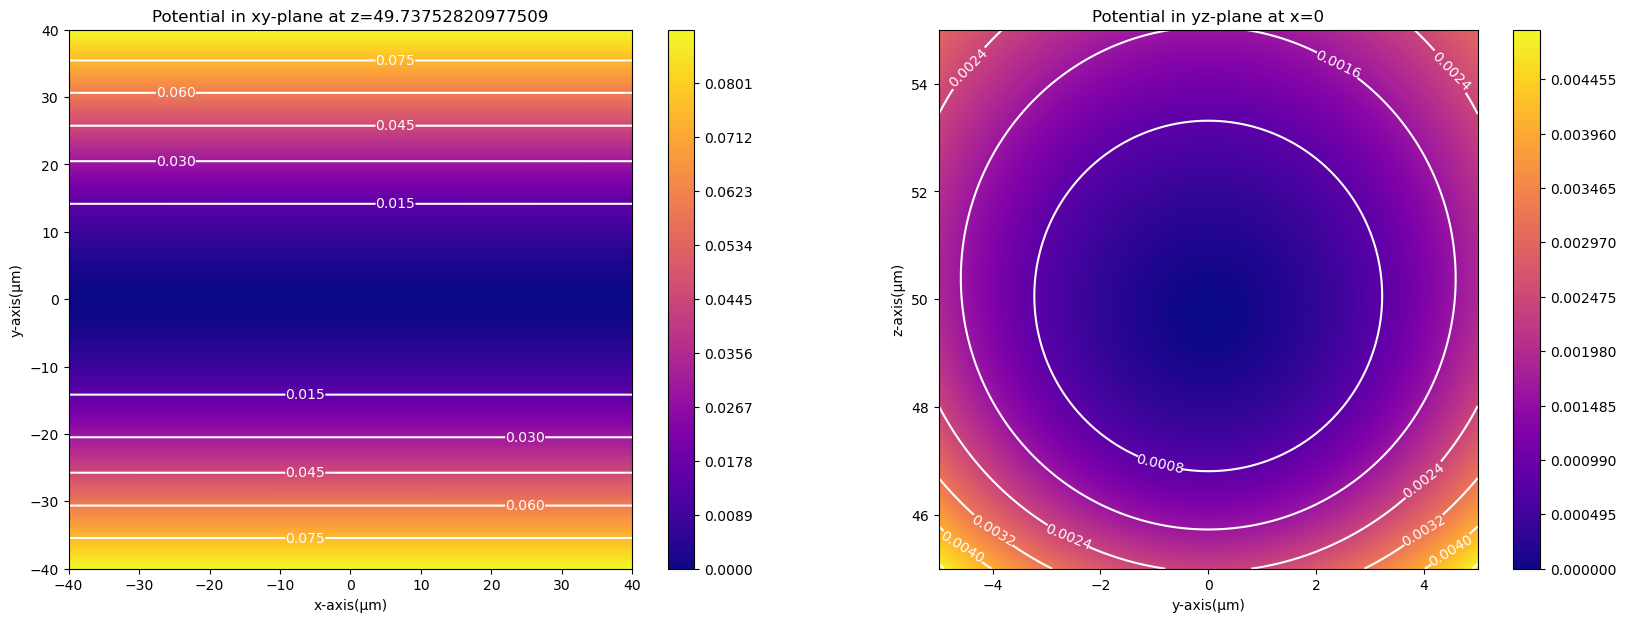

In [398]:
# print(np.mgrid[np.linspace(0, 10), 0:3])
def plot_potential(s=s, z0=z_h):
    import matplotlib.cm as cm
    # make grid for potential view in z = z0 plane - top view looking down
    grid_xy, tsx0, tsy0 = make_xy_grid_flat([-40.,40.], [-40., 40.], z_h, [101, 101])
    # make grid for potential view in x = 0 plane - side view
    d_r = 5.
    grid_yz, tsy1, tsz1 = make_yz_grid_flat(0., [-d_r,d_r], [np.round(z_h)-d_r, np.round(z_h)+d_r], [101, 101])
    grids = [[grid_xy, tsx0, tsy0], [grid_yz, tsy1, tsz1]]
    
    fig, ax = plt.subplots(1, 2, figsize=(20,7))
    contour_res = 1000

    titles = [f'Potential in xy-plane at z={z_h}', f'Potential in yz-plane at x={0}']
    labels = [['x-axis(µm)', 'y-axis(µm)'], ['y-axis(µm)', 'z-axis(µm)']]
    for i in range(2):
        gridpot = s.potential(grids[i][0])
        gridpot = np.reshape(gridpot, (len(grids[i][2]), len(grids[i][1])))
        bgc = ax[i].contourf(grids[i][1], grids[i][2], gridpot, levels=contour_res, cmap=cm.plasma)
        cp = ax[i].contour(grids[i][1], grids[i][2], gridpot, colors='white')
        ax[i].clabel(cp, fontsize=10, colors='white')
        ax[i].set_title(titles[i])
        ax[i].set_xlabel(labels[i][0])
        ax[i].set_ylabel(labels[i][1])
        fig.colorbar(bgc)
    plt.gca().set_aspect('equal')
plot_potential()

# print(np.mgrid[np.linspace(0, 10), 0:3])
# def plot_potential(z0=z_h):
#     # make grid for potential view in z = z0 plane - top view looking down
#     grid_xy, tsy, tsz = make_yz_grid_flat([-40.,40.], [-40., 40.], [201, 201])
#     # make grid for potential view in x = 0 plane - side view
#     grid_yz, tsy1, tsz1 = make_yz_grid_flat(0., [-10.,10.], [40., 60.], [201, 201])
#     gridpot = s.potential(grid_yz)
#     gridpot = np.reshape(gridpot, (len(ts1), len(tsy1)))
#     print(gridpot.shape)
#     fig, ax = plt.subplots(1, 2, figsize=(15,7))
#     plt.gca().set_aspect('equal')
#     contour_res = 1000
#     import matplotlib.cm as cm
#     bgc0 = ax[1].contourf(tsy1, tsz1, gridpot, levels=contour_res, cmap=cm.plasma)
#     cp0 = ax[1].contour(tsy1, tsz1, gridpot, colors='white')

#     bgc0 = ax[1].contourf(tsy1, tsz1, gridpot, levels=contour_res, cmap=cm.plasma)
#     cp0 = ax[1].contour(tsy1, tsz1, gridpot, colors='white')
#     # cp0 = plt.contour(i0, i1, Gmag, levels=discrete_levels, colors='black')
#     ax[1].clabel(cp0, fontsize=10, colors='white')
#     ax[1].colorbar(bgc0)
# plot_potential()

## Important function for solving for curvatures and axial frequencies

Target axial frequency: 1000000.0 Hz
DC curvature needed 1.6366598620507583e-05 V/µm^2
DC Voltage needs scaling up by: 4.091649655126896


Basis axial DC voltage set:
 0     0.000000
1     0.000000
2    -1.818211
3     1.279843
4    -0.482178
5     1.279843
6    -1.818211
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11   -1.818211
12    1.279843
13   -0.482178
14    1.279843
15   -1.818211
16    0.000000
17    0.000000
18    0.015206
19    0.015206
20    0.000000
21    0.000000
Name: V, dtype: float64
Scaled axial DC voltage set:
 0     0.000000
1     0.000000
2    -7.439482
3     5.236670
4    -1.972903
5     5.236670
6    -7.439482
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11   -7.439482
12    5.236670
13   -1.972903
14    5.236670
15   -7.439482
16    0.000000
17    0.000000
18    0.062219
19    0.062219
20    0.000000
21    0.000000
Name: V, dtype: float64
Target radial frequency: 3000000.0 Hz
Curvature needed: 0.00014729938758456824 V/µm^2
Curvatur

/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_2966/3132297329.py:29: RuntimeWarning: invalid value encountered in divide
  dc_div = np.array(u_dc)/np.array(u_dc_ref)
/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_2966/3132297329.py:71: RuntimeWarning: invalid value encountered in sqrt
  f_rad_initial = np.sqrt(q*curves/m)/(2*np.pi*l)
/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_2966/3132297329.py:96: RuntimeWarning: invalid value encountered in sqrt
  f_rad = np.sqrt(q*curves/m)/(2*np.pi*l)


Curvature: [1.65037901e-05 1.47097209e-04 1.47364374e-04]
Mathieu frequency 1: 1.0041825112035132 MHz [ 9.97766654e-01 -1.05226493e-14 -5.35987703e-15]
Mathieu frequency 2: 3.048300356486674 MHz [3.34708748e-18 1.94107182e-13 9.54841131e-01]
Mathieu frequency 3: 3.0522707236378346 MHz [-9.15608251e-17  9.54896925e-01 -1.43397090e-12]
[0.05078194 0.05078161 0.05078129 ... 0.05078129 0.05078161 0.05078194]
49.73947477589811
[[ 0.          0.         39.73947478]
 [ 0.          0.         39.74147498]
 [ 0.          0.         39.74347518]
 ...
 [ 0.          0.         59.73547438]
 [ 0.          0.         59.73747458]
 [ 0.          0.         59.73947478]]


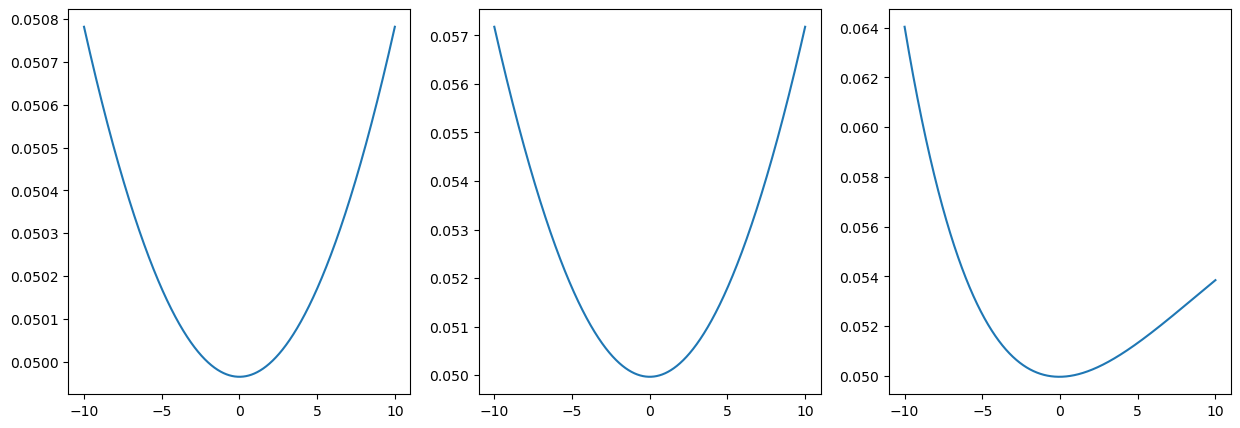

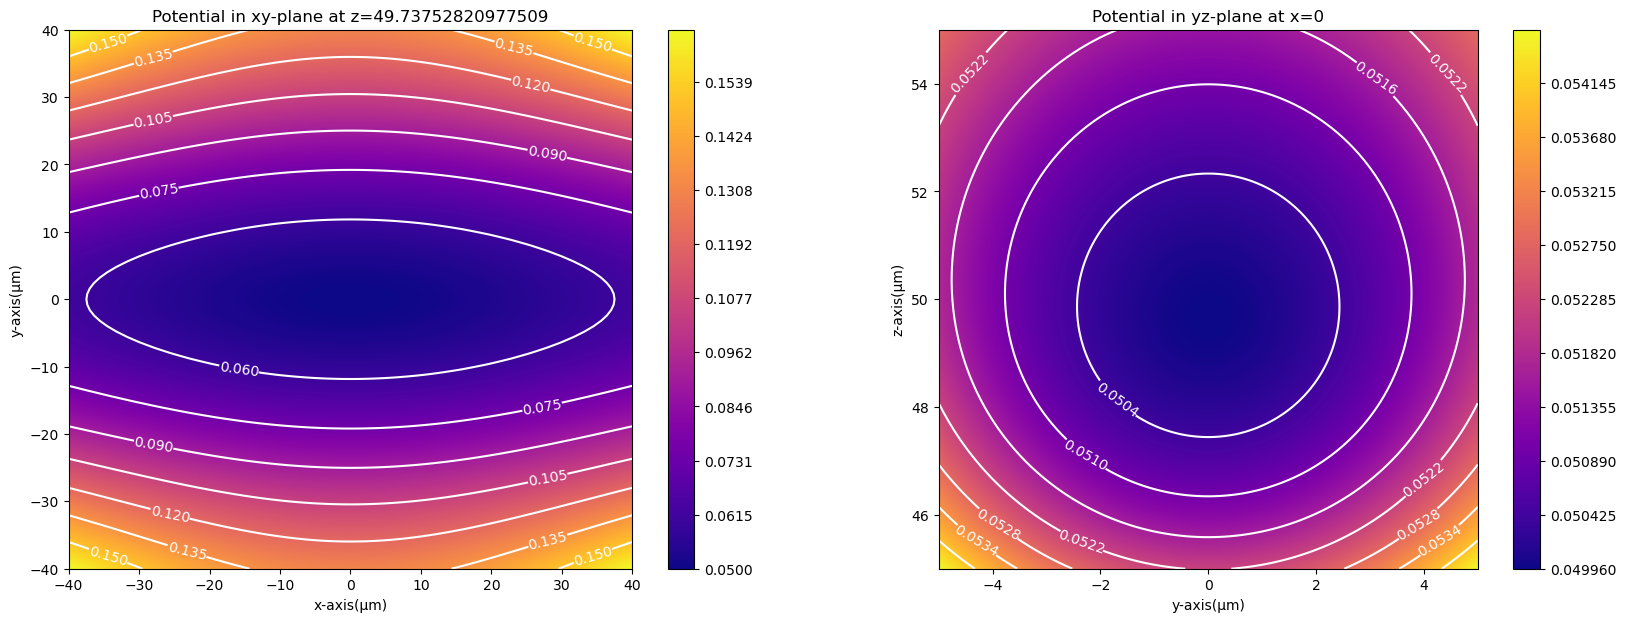

In [399]:
def solve_freqs(s=s, f_rad = 3e6, f_axial = 1e6, f_traprf = 30e6,
                m = 40*ct.atomic_mass, q = 1*ct.elementary_charge,
                l = 1e-6, u_dc_ref = [0, 4e-6, 0, -2e-6, 0, -2e-6],
                dc_axial_set_file="Vs_2024-02-18_axial.csv",
                do_plot_potential=True):
    # 3 MHz radial frequency default target
    o_rad = 2 * np.pi * f_rad
    # 1 MHz axial frequency default target
    # 30MHz trap rf default
    o_traprf = 2 * np.pi * f_traprf
    # 40Ca+ ion mass
    # +1 ion charge
    # 1µm length scale

    ### 1. solve the DC curvature needed for 1MHz
    o_axial = 2 * np.pi * f_axial
    u_axial = o_axial**2 * m * l**2 / q
    print("Target axial frequency:", f_axial, "Hz")
    print("DC curvature needed", u_axial, "V/µm^2")

    # by laplace's equation, laplacian of dc potential
    # in free space is 0. use (+2, -1, -1) distribution.
    # have solved for the dc voltage sets previously.

    radial_anticonfinement = u_axial / 2

    # dc curvature scales linearly with voltage.
    u_dc = [0, u_axial, 0, -radial_anticonfinement, 0, -radial_anticonfinement]
    dc_div = np.array(u_dc)/np.array(u_dc_ref)
    vdc_scaling = np.max(dc_div[np.isfinite(dc_div)])
    print("DC Voltage needs scaling up by:", vdc_scaling)


    print("\n")

    ### read axial basis voltage set
    # scale up by required dc sclaing
    dc_df = pd.read_csv(dc_axial_set_file)
    dc_axial_set = dc_df["V"]
    print("Basis axial DC voltage set:\n", dc_axial_set.T)
    dc_axial_set *= vdc_scaling
    print("Scaled axial DC voltage set:\n", dc_axial_set.T)
    dc_axial_set = np.array(dc_axial_set)

    ### 2. solve required pp curvature for 3MHz
    # with additional anticonfinement
    # and corresponding v_peak

    # assume (ux, uy, uz) is the pp curvature needed for 3MHz
    # radial frequencies. need to scale to:
    # (ux', uy+dc_anticonf, uz+dc_anticonf)

    u_rad = o_rad**2 * m * l**2 / q
    print("Target radial frequency:", f_rad, "Hz")
    print("Curvature needed:", u_rad, "V/µm^2")

    u_rad += radial_anticonfinement
    print("Curvature with anticonfinement compensation needed:", u_rad, "V/µm^2")

    print("\n")

    # find curvature produced at v_p = 10V

    vp = 10.
    s["r"].rf = vp*np.sqrt(q/m)/(2*l*o_traprf)
    x_guess = [0., 0., 50.]
    x0 = s.minimum(x_guess)
    print("PP saddle point found at:", x0, "µm")

    curves, modes_pp = s.modes(x0)
    f_rad_initial = np.sqrt(q*curves/m)/(2*np.pi*l)

    print(f"V_peak = {vp}V.")
    print("Curvature:", curves)
    print("Initial radial frequencies:", f_rad_initial)

    # since curvature scales as V_peak^2,
    # want y,z-axis curvatures to scale to target u_rad.
    # calculate using mean of y,z curvatures

    curvature_scaling = u_rad / np.mean([curves[1], curves[2]])
    print("Curvature needs scaling up by:", curvature_scaling)
    vp_scaling = np.sqrt(curvature_scaling)
    print("RF Voltage needs scaling up by:", vp_scaling)

    print("\n")
    print("Post-scaling")

    vp *= vp_scaling
    s["r"].rf = vp*np.sqrt(q/m)/(2*l*o_traprf)
    x_guess = [0., 0., 50.]
    x0 = s.minimum(x_guess)
    print("PP saddle point found at:", x0, "µm")

    curves, modes_pp = s.modes(x0)
    f_rad = np.sqrt(q*curves/m)/(2*np.pi*l)

    print(f"Scaled V_peak = {vp}V.")
    print("Curvature:", curves)
    print("Scaled radial frequencies:", f_rad)

    print("\n")

    with s.with_voltages(dc_axial_set):
        tmp_len = 20
        res = 10000
        shift = {'z': x0[2]}
        x3d, x = single_axis('x', (-tmp_len/2,tmp_len/2), res, shift=shift)
        y3d, y = single_axis('y', (-tmp_len/2,tmp_len/2), res, shift=shift)
        z3d, z = single_axis('z', (-tmp_len/2,tmp_len/2), res, shift=shift)
        vx = s.potential(x3d, 0).T
        vy = s.potential(y3d, 0).T
        vz = s.potential(z3d, 0).T
        fig, ax = plt.subplots(1, 3, figsize=(15,5))
        ax = ax.flat
        curves, modes_pp = s.modes(x0)
        print("Curvature:", curves)
        # make plots of overall rf + dc potential
        ax[0].plot(x, vx, label='Electrode contribution')
        ax[1].plot(y, vy, label='Electrode contribution')
        ax[2].plot(z, vz, label='Electrode contribution')

        # uncomment for static & mathieu analysis
        rf_scale = s.rf_scale(m, q, l, o_traprf)
        mu, b = s.mathieu(x0, scale=rf_scale, r=4, sorted=True)
        freqs = mu[:3].imag*o/(2*np.pi)
        modes = b[len(b)//2 - 3:len(b)//2, :3].real
        for i in range(len(freqs)):
            print(f"Mathieu frequency {i+1}:", freqs[i]/1e6, "MHz", modes[i])
        '''
        for line in s.analyze_static(x0, axis=(1, 2), m=m, q=q, l=l, o=o_traprf):
            print(line)
        '''
        if(do_plot_potential):
            plot_potential(s=s, z0=x0[2])
        print(vx)
        print(x0[2])
        print(z3d)
        
    
    




solve_freqs()

In [426]:
electrode_voltages_v2 = np.array([
    0, 2.6378, 2.6378, -2.0898, -2.0898, -2.0898, 2.6378, 2.6378, 0, 0, 2.6378, 2.6378, -2.0898, -2.0898, -2.0898, 2.6378, 2.6378, 0, -0.50453, -0.50453, 0, 0
])

with s.with_voltages(electrode_voltages_v2):
    ep = s.electrical_potential([0,0,z_h], "dc", 2, expand=True)
    sum = 0
    # ep = ep.flatten()
    print(ep)
    # print(ep[0, 1, 1], len(ep))
    # print(ep[0][1])
    for i in range(3):
        # n = i % 3
        # if (n == 0):
        sum += ep[0, i, i] 
        print(ep[0, i, i])
    print("dc only potential:", sum)

    # curvature needed for 3MHz
    u_rad = 0.00014729938758456824
    '''
    V_peak = 10.0V.
    Curvature: [-9.76898229e-14  5.23076705e-05  5.23346839e-05]
    '''

    print("y-axis")
    u_rad_y = u_rad - ep[0, 1, 1]
    curv10v = [-9.76898229e-14, 5.23076705e-05, 5.23346839e-05]
    curvature_scaling = u_rad_y / np.mean([curv10v[1], curv10v[2]])
    print("Curvature needs scaling up by:", curvature_scaling)
    vp_scaling = np.sqrt(curvature_scaling)
    print("RF Voltage needs scaling up by:", vp_scaling)
    u_z = u_rad_y + ep[0, 2, 2]
    print("curvature in z", u_z)
    f_rad_z = np.sqrt(q*u_z/m)/(2*np.pi*l)
    print("frequency in z", f_rad_z)

    print("z-axis")
    u_rad_z = u_rad - ep[0, 2, 2]
    curv10v = [-9.76898229e-14, 5.23076705e-05, 5.23346839e-05]
    curvature_scaling = u_rad_z / np.mean([curv10v[1], curv10v[2]])
    print("Curvature needs scaling up by:", curvature_scaling)
    vp_scaling = np.sqrt(curvature_scaling)
    print("RF Voltage needs scaling up by:", vp_scaling)
    u_y = u_rad_z + ep[0, 1, 1]
    print("curvature in y", u_y)
    f_rad_y = np.sqrt(q*u_y/m)/(2*np.pi*l)
    print("frequency in y", f_rad_y)



[[[ 1.29970600e-05  2.64697796e-23  1.05879118e-21]
  [ 2.64697796e-23  3.42053644e-06  0.00000000e+00]
  [ 1.05879118e-21  0.00000000e+00 -1.64175964e-05]]]
1.2997059969131745e-05
3.420536440746239e-06
-1.6417596409877982e-05
dc only potential: 0.0
y-axis
Curvature needs scaling up by: 2.749916168625923
RF Voltage needs scaling up by: 1.658287118874751
curvature in z 0.000127461254733944
frequency in z 2790678.9646427627
z-axis
Curvature needs scaling up by: 3.1290768433712963
RF Voltage needs scaling up by: 1.7689196825665365
curvature in y 0.00016713752043519248
frequency in y 3195639.359549259


In [402]:
def tilt_single_axis(theta, axis, bounds, res, shift={'z': z_h}):
    '''
    theta in radians.
    '''
    ts = np.linspace(bounds[0], bounds[1], res)
    ts_cos = ts * np.cos(theta)
    ts_sin = ts * np.sin(theta)
    zeros = np.zeros(res)
    line = ts
    line3d = []
    if (axis == 'y_prime'):
        line3d = np.column_stack([zeros, ts_cos.T, ts_sin.T])
    if (axis == 'z_prime'):
        line3d = np.column_stack([zeros, -ts_sin.T, ts_cos.T])

    # to shift line height
    for key, val in shift.items():
        if (key == 'x'):
            line3d += np.column_stack([np.ones(res) * val, zeros, zeros])
        if (key == 'y'):
            line3d += np.column_stack([zeros, np.ones(res) * val, zeros])
        if (key == 'z'):
            line3d += np.column_stack([zeros, zeros, np.ones(res) * val])
    return line3d, line

[[ 0.         -2.16506351 48.48752821]
 [ 0.         -2.1646305  48.48777821]
 [ 0.         -2.16419748 48.48802821]
 ...
 [ 0.          2.16419748 50.98702821]
 [ 0.          2.1646305  50.98727821]
 [ 0.          2.16506351 50.98752821]]


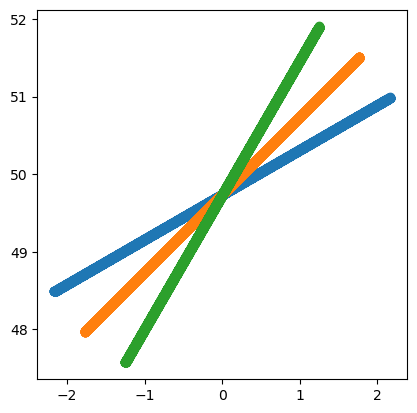

In [413]:
t_len = 10
y3d_p, y_prime = tilt_single_axis(np.pi/6, 'y_prime', (-t_len/4, t_len/4), res)
y3d_p2, y_prime2 = tilt_single_axis(np.pi/4, 'y_prime', (-t_len/4, t_len/4), res)
y3d_p3, y_prime3 = tilt_single_axis(np.pi/3, 'y_prime', (-t_len/4, t_len/4), res)
print(y3d_p)
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(y3d_p[:, 1], y3d_p[:, 2])
ax.scatter(y3d_p2[:, 1], y3d_p2[:, 2])
ax.scatter(y3d_p3[:, 1], y3d_p3[:, 2])
plt.gca().set_aspect('equal')
# ax = fig.add_subplot(projection='3d')
# ax.scatter(y3d_p[:, 0], y3d_p[:, 1], y3d_p[:, 2])
# z3d, z = tilt_single_axis('z', (0,length/2), res)

[[ 0.          1.25       47.5724647 ]
 [ 0.          1.24975    47.57289771]
 [ 0.          1.2495     47.57333073]
 ...
 [ 0.         -1.2495     51.90172569]
 [ 0.         -1.24975    51.90215871]
 [ 0.         -1.25       51.90259172]]


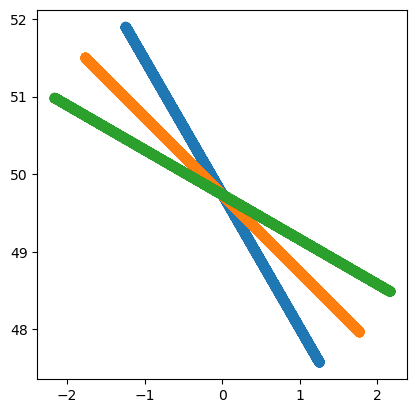

In [415]:
t_len = 10
y3d_p, y_prime = tilt_single_axis(np.pi/6, 'z_prime', (-t_len/4, t_len/4), res)
y3d_p2, y_prime2 = tilt_single_axis(np.pi/4, 'z_prime', (-t_len/4, t_len/4), res)
y3d_p3, y_prime3 = tilt_single_axis(np.pi/3, 'z_prime', (-t_len/4, t_len/4), res)
print(y3d_p)
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(y3d_p[:, 1], y3d_p[:, 2])
ax.scatter(y3d_p2[:, 1], y3d_p2[:, 2])
ax.scatter(y3d_p3[:, 1], y3d_p3[:, 2])
plt.gca().set_aspect('equal')

In [331]:
example = np.arange(0, 10)
e5 = np.arange(0, 5)
np.savetxt('asa.txt', np.array([example, example, e5]))
np.loadtxt('asa.txt')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

[1.2206614059331047e-11, 2.3812428154854166e-05, 2.3085888970448642e-05]
1.587495210323611e-05 1.5874952103236113e-05 1.5148412918830587e-05
[ 0.00000000e+00  7.93747605e-06  0.00000000e+00 -3.96873803e-06
  0.00000000e+00 -3.96873803e-06]
[ 0.06034977 -7.21600311 -1.91363793 -7.21600311  5.0793622   5.0793622 ]
[ 0.          0.         -7.21600311  5.0793622  -1.91363793  5.0793622
 -7.21600311  0.          0.          0.          0.         -7.21600311
  5.0793622  -1.91363793  5.0793622  -7.21600311  0.          0.
  0.06034977  0.06034977  0.          0.        ]
new minimum x0_prime: [-2.20995528e-14 -2.94919502e-14  4.92242524e+01]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Overall potential:  [[[ 1.60022313e-05 -1.05879118e-21  2.54109884e-21]
  [-1.05879118e-21  1.61781236e-05  3.38203005e-21]
  [ 2.54109884e-21  3.38203005e-21  1.47179744e-05]]]
[0.04846628]
parameters:
 f=30 MHz, m=40 amu, q=1 qe, l=1 µm, scale=4.12 V'/V_SI
corrdinates:
 analyze point: [-2.20995528e-14 -2.94919502e-14  4.92242524e+01]
               ([-2.20995528e-14 -2.94919502e-14  4.92242524e+01] µm)
 minimum is at offset: [0. 0. 0.]
                      ([0. 0. 0.] µm)
potential:
 dc electrical: 0.048 eV
 rf pseudo: 3.4e-06 eV
 saddle offset: [0.4340403  0.52092487 0.56833342]
               ([0.4340403  0.52092487 0.56833342] µm)
 saddle height: 5.7e-06 eV
force:
 dc electrical: [1.62630326e-18 7.04731412e-19 1.16674294e-05] eV/l
               ([1.62630326e-12 7.04731412e-13 1.16674294e+01] eV/m)
 rf pseudo: [ 0.00000000e+00 -7.98199409e-22 -1.32029407e-05] eV/l
           ([ 0.00000000e+00 -7.98199409e-16 -1.32029407e+01] eV/m)
modes:
 pp+dc normal curvatures: [1.60167017e-05 

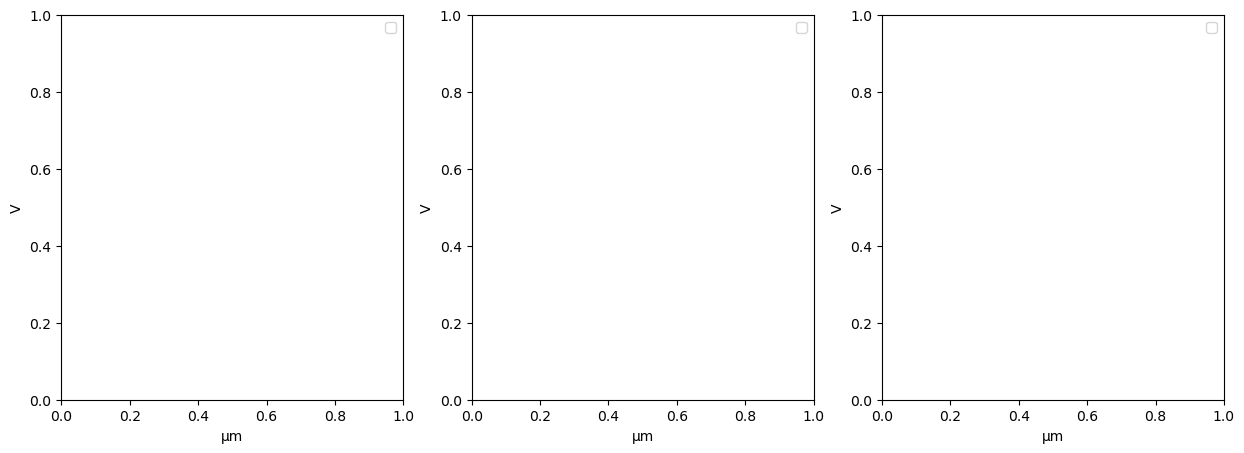

In [249]:
l = 1e-6 # µm length scale
# u = 10. # V rf peak voltage

u = 6.8 # best so far set 1
# u = 1.0
f = 30e6 
# f = 50e6 

# u = 8.
# f = 35e6

m = 40*ct.atomic_mass # 40Ca+ ion mass
q = 1*ct.elementary_charge # ion charge

o = 2*np.pi*f # rf frequency in rad/s
s["r"].rf = u*np.sqrt(q/m)/(2*l*o)

# find curvatures due to pseudopotential
derivative = 2
pp = s.pseudo_potential(x0, derivative=derivative)
pp_axes = []
for i in range(derivative + 1):
    pp_axes.append(pp[0, i, i])

print(pp_axes)

# set these as constraints for the dc potential to get equal curvatures in rf+dc
# approximate solution assuming rf_curvature_y = rf_curvature_z
# rf curvature_y + dc curvature_y (negative) = dc_curvature_x
# -2 * dc curvature_y (negative) = dc_curvature_x
# this gives dc_curvature_x = 2/3 rf_curvature_y

x = 2/3 * pp_axes[1]
x1 = x2 = x/2

# exact solution without assuming the above
# x = dc_curvature_x
# rf_curvature_y =  x1 + x = 2* x1 + x2
# rf_curvature_z =  x2 + x = x1 + 2* x2
# x1 + x2 = x
'''
# Uncomment these lines
x1 = (pp_axes[1] - pp_axes[2]/2)/1.5
x2 = pp_axes[2] - (pp_axes[1] - x1)
x = x1 + x2
'''
print(x1+x2, pp_axes[1]-x1, pp_axes[2]-x2)
constraint = np.array([0, x, 0, -x1, 0, -x2])/2
print(constraint)


# solve for voltages giving the constraint

groups = [['1', '11'], ['4', '14'], ['6', '16'], ['8', '18'], ['5', '7'], ['15', '17']]
group_voltages = solve_voltages(s.names, overall_fitted_coeffs, constraint, groups=groups)
print(group_voltages)

el_v = np.zeros(len(s.names))
for i in range(len(groups)):
    for electrode_name in groups[i]:
        el_v[s.names.index(electrode_name)] = group_voltages[i]
# el_v[s.names.index('r')] = u*np.sqrt(q/m)/(2*l*o)
print(el_v)
tmp_len = 200

with s.with_voltages(el_v):
    x0_prime = s.minimum(x0)
    print("new minimum x0_prime:", x0_prime)
    shift = {'z': x0_prime[2]}
    x3d, x = single_axis('x', (-tmp_len/2,tmp_len/2), res, shift=shift)
    y3d, y = single_axis('y', (-tmp_len/2,tmp_len/2), res, shift=shift)
    z3d, z = single_axis('z', (-tmp_len/2,tmp_len/2), res, shift=shift)
    # vx = s.electrical_potential(x3d).T
    # vy = s.electrical_potential(y3d).T
    # vz = s.electrical_potential(z3d).T
    vx = s.potential(x3d, 0).T
    vy = s.potential(y3d, 0).T
    vz = s.potential(z3d, 0).T
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax = ax.flat
    # TODO: Make plots of overall rf + dc potential
    # print(vx)
    # ax[0].plot(x, vx[0], label='Electrode contribution')
    # # ax[0].plot(x, b[1] * x**2 +vx[0][int((vx.size+1)/2)], label='Allcock curvature')
    # ax[0].set_title('x-axis')
    # ax[1].plot(y, vy[0], label='Electrode contribution')
    # # ax[1].plot(y, b[3] * y**2 +vy[0][int((vy.size+1)/2)], label='Allcock curvature')
    # ax[1].set_title('y-axis')
    # ax[2].plot(z+x0_prime[2], vz[0], label='Electrode contribution')
    # ax[2].set_title('z-axis')
    # ax[2].axvline(x=x0_prime[2], linestyle='--', color='r')
    # ax[2].plot(z+z_h, b[-1] * z**2 +vz[0][int((vz.size+1)/2)], label='Allcock curvature')
    for i in range(3):
        ax[i].set_xlabel('µm')
        ax[i].set_ylabel('V')
        ax[i].legend()

    print('Overall potential: ', s.potential(x0, 2))
    print(s.potential(x0))

    for line in s.analyze_static(x0_prime, axis=(1, 2), m=m, q=q, l=l, o=o):
        print(line)
for line in s.analyze_static(x0, axis=(1, 2), m=m, q=q, l=l, o=o):
        print(line)

In [132]:
x1 / 2 / 1e-6

4.2722913645201315

In [146]:
pp = s.pseudo_potential([0,0,z_h], 2)
print("Pseudopotential:", pp)
# ps = s.potential([0,0,z_h], 2)
# print("" ps)
with s.with_voltages(3.203 *electrode_voltages):
    ep = s.electrical_potential([0,0,z_h], "dc", 2, expand=True)
    print("dc only potential:", ep)
    ps = s.potential([0,0,z_h], 2)
    print("total rf+dc potential:", ps)
    m = 40 * ct.atomic_mass
    for line in s.analyze_static(x0, axis=(1, 2), m=m, q=q, l=l, o=o):
        print(line)

Pseudopotential: [[[-1.45664146e-13  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  2.56337482e-05  1.91872052e-25]
  [ 0.00000000e+00  1.91872052e-25  2.56529671e-05]]]
dc only potential: [[[ 1.29194277e-05  6.35274710e-22  3.38813179e-21]
  [ 6.35274710e-22 -6.32492408e-06 -8.47032947e-22]
  [ 3.38813179e-21 -8.47032947e-22 -6.59450365e-06]]]
total rf+dc potential: [[[ 1.29194276e-05  6.35274710e-22  3.38813179e-21]
  [ 6.35274710e-22  1.93088241e-05 -8.46841075e-22]
  [ 3.38813179e-21 -8.46841075e-22  1.90584634e-05]]]
parameters:
 f=30 MHz, m=40 amu, q=1 qe, l=1 µm, scale=4.12 V'/V_SI
corrdinates:
 analyze point: [0.00000000e+00 4.34002626e-15 4.97375282e+01]
               ([0.00000000e+00 4.34002626e-15 4.97375282e+01] µm)
 minimum is at offset: [0. 0. 0.]
                      ([0. 0. 0.] µm)
potential:
 dc electrical: 0.039 eV
 rf pseudo: 8e-10 eV
 saddle offset: [0.73545525 0.30847499 0.23905892]
               ([0.73545525 0.30847499 0.23905892] µm)
 saddle height: 6.3e-

In [51]:
# self-calculating the oscillation modes, why doesn't this match with the analysis?
e = 1.6e-19
m = 1.67e-27
rm = 40
u_i = 2e6
v_i = 2.5e7
om_rf = 30e6 * 2 * np.pi
om_i = np.sqrt(e*u_i/(m*rm) + (e**2 * v_i**2)/(2*(m*rm)**2 * (om_rf)**2))
print("slow secular harmonic omega:", om_i)

om_2 = e*v_i / (np.sqrt(2) * m*rm * om_rf)
print(om_2)

slow secular harmonic omega: 2200199.472193496
224629.81940047554


In [14]:
#2019 vs2 transposed to center
electrode_voltages_v2 = np.array([
    0, 2.6378, 2.6378, -2.0898, -2.0898, -2.0898, 2.6378, 2.6378, 0, 0, 2.6378, 2.6378, -2.0898, -2.0898, -2.0898, 2.6378, 2.6378, 0, -0.50453, -0.50453, 0, 0
])

with s.with_voltages(electrode_voltages_v2):
    ep = s.electrical_potential([0,0,z_h], "dc", 2, expand=True)
    sum = 0
    # ep = ep.flatten()
    print(ep)
    print(ep[0, 1, 1], len(ep))
    print(ep[0][1])
    for i in range(3):
        # n = i % 3
        # if (n == 0):
        sum += ep[0, i, i] 
        print(ep[0, i, i])
    print("dc only potential:", sum)

[[[ 1.29970600e-05  2.64697796e-23  1.05879118e-21]
  [ 2.64697796e-23  3.42053644e-06  0.00000000e+00]
  [ 1.05879118e-21  0.00000000e+00 -1.64175964e-05]]]
3.420536440746239e-06 1
[2.64697796e-23 3.42053644e-06 0.00000000e+00]
1.2997059969131745e-05
3.420536440746239e-06
-1.6417596409877982e-05
dc only potential: 0.0


Grouping electrode potentials

In [16]:

A = np.array(overall_fitted_coeffs)
# clean values below 1e-17
# A[np.abs(A)<1e-17] = 0
# remove constant terms from matrix
A = np.delete(A, [0, 3, 6], 1)
# remove rf and gnd electrodes
A = np.delete(A, [-1, -2], 0)
# print(A)
#b = np.zeros(6)
# b = np.array([0, 2e-6, 0,-1e-6,0,-1e-6])
b = np.array([0, 2e-6,-1e-6,0,-1e-6])
# b = np.array([ 2.04e-6, 0, -1.02e-6, 0, -1.02e-6])
# group electrodes by adding their coefficients
# 1: 4 and 14
# 2: 8 and 18
# 3: 5, 6, 7 and 15, 16, 17
# 4: assume all others grounded

A_grouped = []
#experiment 11/15: try using 3 electrode groups for tilt voltage, since we only need the 2nd order terms
b = np.array([2e-6,-1e-6,-1e-6])
groups = [['1', '11'], ['4', '14', '8', '18'], ['5', '6', '7', '15', '16', '17']]


# groups = [['1', '11'], ['4', '14'], ['6', '16'], ['5', '15', '7', '17'], ['8', '18']] # this one actually returns physically feasible results

# groups = [['1'], ['11'], ['4', '14'], ['8', '18'], ['5', '6', '7'], ['15', '16', '17']]
# groups = [['1', '11'], ['4', '8'], ['14', '18'], ['5', '6', '7'], ['15', '16', '17']]
for group in groups:
    # group_coeffs = np.zeros(len(b))
    # group_coeffs = np.zeros(len(b)+1)
    group_coeffs = np.zeros(6)
    for electrode_name in group:
        # print(group_coeffs.shape)
        # print(np.array(A[s.names.index(electrode_name)]).shape)
        # group_coeffs = group_coeffs + np.array(A[np.where(s.names == electrode_name)]).flatten()
        group_coeffs += np.array(A[s.names.index(electrode_name)])
        # print(group_coeffs)
    # for item in range(len(group_coeffs)):
    #     if(np.abs(group_coeffs[item]) < 1e-17):
    #         group_coeffs[item] = 0
    # print(group_coeffs)
    A_grouped.append(group_coeffs)
# target [c_x0, c_x1, c_x2, c_x0, c_x1, c_x2]
# endcap from Allcock paper
# b = np.array([0, -1.02e-6, 0, -1.02e-6, 0, 2.04e-6])
A_grouped = np.array(A_grouped)
A_grouped[np.abs(A_grouped)<1e-17] = 0
# for i in range(A_grouped.shape[1]):
#     column = i%2
#     A_grouped[:,i] = A_grouped[:,i] * 10**(6+(i%2)*6)
    # A_grouped[:,1] = A_grouped[:,1] * 1e12

# needed to delete empty row
print(A_grouped)
A_grouped = np.delete(A_grouped, [0, 2, 4], 1)

print(A_grouped)
# soln1 = np.linalg.solve(np.matmul(A_grouped, A_grouped.T), np.matmul(A_grouped, b))
soln2 = np.linalg.solve(A_grouped.T, b)
# soln2 = np.linalg.lstsq(A_grouped, b.T, rcond=None)
# print(soln1)

print(soln2)

[[ 0.00000000e+00 -2.08922316e-09  0.00000000e+00 -8.01547350e-05
  -5.12142484e-03  8.18247073e-05]
 [ 0.00000000e+00  9.63530935e-07  0.00000000e+00  4.73429469e-07
   7.19604703e-04 -1.43623790e-06]
 [ 0.00000000e+00 -1.51861905e-06  0.00000000e+00  1.98707173e-05
   2.60794882e-03 -1.82482392e-05]]
[[-2.08922316e-09 -8.01547350e-05  8.18247073e-05]
 [ 9.63530935e-07  4.73429469e-07 -1.43623790e-06]
 [-1.51861905e-06  1.98707173e-05 -1.82482392e-05]]
[ 0.00414133  1.94951269 -0.08006805]


[ 0.          0.          1.94951269 -0.08006805 -0.08006805 -0.08006805
  1.94951269  0.          0.          0.          0.          1.94951269
 -0.08006805 -0.08006805 -0.08006805  1.94951269  0.          0.
  0.00414133  0.00414133  0.          0.        ]
[[0.04201352 0.0420159  0.04201827 ... 0.04201827 0.0420159  0.04201352]]
(100001,)
[-500.   -499.99 -499.98 ...  499.98  499.99  500.  ]


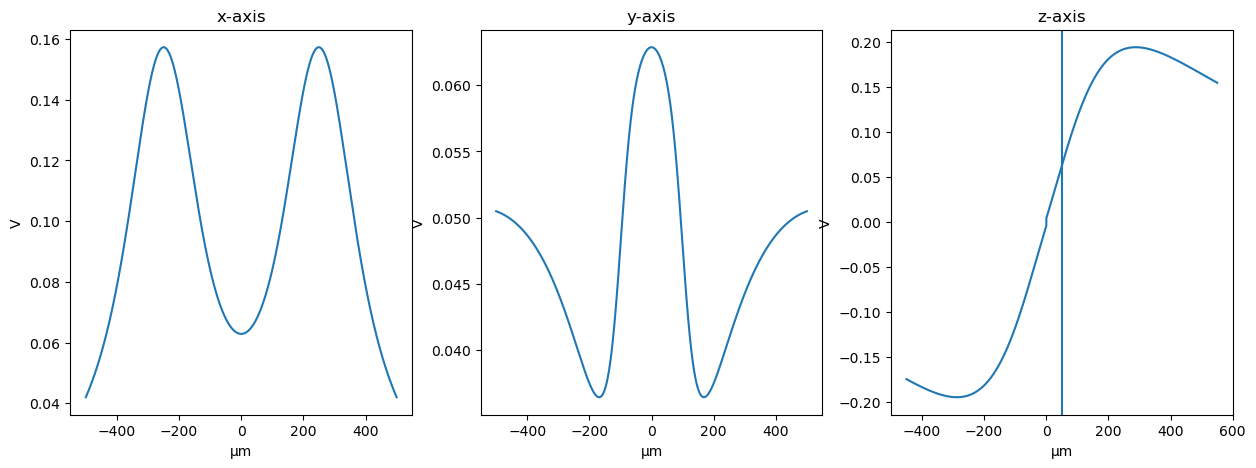

In [21]:
electrode_voltages = np.zeros(len(s.names))
for i in range(len(groups)):
    # group_coeffs = np.zeros(len(b))
    for electrode_name in groups[i]:
        electrode_voltages[s.names.index(electrode_name)] = soln2[i]
print(electrode_voltages)
tmp_len = 1000
x3d, x = single_axis('x', (-tmp_len/2,tmp_len/2), res)
y3d, y = single_axis('y', (-tmp_len/2,tmp_len/2), res)
z3d, z = single_axis('z', (-tmp_len/2,tmp_len/2), res)

with s.with_voltages(electrode_voltages):
    vx = s.electrical_potential(x3d).T
    vy = s.electrical_potential(y3d).T
    vz = s.electrical_potential(z3d).T
    print(vx)
    print(x.shape)
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax = ax.flat
    ax[0].plot(x, vx[0], label='x-axis')
    ax[0].set_title('x-axis')
    ax[1].plot(y, vy[0], label='y-axis')
    ax[1].set_title('y-axis')
    ax[2].plot(z+50, vz[0], label='z-axis')
    ax[2].set_title('z-axis')
    ax[2].axvline(x=50)
    for i in range(3):
        ax[i].set_xlabel('µm')
        ax[i].set_ylabel('V')

print(z)

In [41]:
print(A_grouped)

[[-1.07269609e-19 -1.04461162e-09  1.22999914e-03 -4.00772485e-05
   6.90435941e-02 -6.41235976e-04]
 [-1.02115653e-19 -1.04461162e-09 -1.22999914e-03 -4.00772485e-05
   5.92036010e-02 -6.41235976e-04]
 [-6.77626358e-20  4.81765520e-07  1.03869628e-04  2.36714689e-07
   3.67350093e-05  3.78743503e-06]
 [ 0.00000000e+00  4.81765520e-07 -1.03869628e-04  2.36714689e-07
  -7.94222016e-04  3.78743503e-06]
 [ 2.43945489e-19 -7.59309600e-07  1.09591919e-03  9.93536624e-06
  -1.15129092e-02  1.58965860e-04]
 [ 1.62630326e-19 -7.59309600e-07 -1.09591919e-03  9.93536624e-06
  -2.02802627e-02  1.58965860e-04]]


Grouping with 3 degrees of freedom 5 electrodes per side

Grouping with 6 degrees of freedom

In [52]:

A = np.array(overall_fitted_coeffs)
# clean values below 1e-17
# A[np.abs(A)<1e-17] = 0
# remove constant terms from matrix
A = np.delete(A, [0, 3, 6], 1)
# remove rf and gnd electrodes
A = np.delete(A, [-1, -2], 0)
# print(A)
#b = np.zeros(6)
b = np.array([0, 2e-6, 0,-1e-6,0,-1e-6])
# b = np.array([0, 2e-6,-1e-6,0,-1e-6])
# b = np.array([ 2.04e-6, -1.02e-6, -1.02e-6])
# group electrodes by adding their coefficients
# 1: 4 and 14
# 2: 8 and 18
# 3: 5, 6, 7 and 15, 16, 17
# 4: assume all others grounded

A_grouped = []
#experiment 11/15: try using 3 electrode groups for tilt voltage, since we only need the 2nd order terms
# b = np.array([2e-6,-1e-6,-1e-6])
# groups = [['1', '11'], ['4', '14', '8', '18'], ['5', '6', '7', '15', '16', '17']]


# groups = [['1', '11'], ['4', '14'], ['6', '16'], ['5', '15', '7', '17'], ['8', '18']] # this one actually returns physically feasible results

# groups = [['1'], ['11'], ['4', '8'], ['14', '18'], ['5', '6', '7'], ['15', '16', '17']] # gives singular matrix
groups = [['1', '11'], ['4', '14'], ['6', '16'], ['8', '18'], ['5', '7'], ['15', '17']]
for group in groups:
    # group_coeffs = np.zeros(len(b))
    # group_coeffs = np.zeros(len(b)+1)
    group_coeffs = np.zeros(6)
    for electrode_name in group:
        # print(group_coeffs.shape)
        # print(np.array(A[s.names.index(electrode_name)]).shape)
        # group_coeffs = group_coeffs + np.array(A[np.where(s.names == electrode_name)]).flatten()
        group_coeffs += np.array(A[s.names.index(electrode_name)])
        # print(group_coeffs)
    # for item in range(len(group_coeffs)):
    #     if(np.abs(group_coeffs[item]) < 1e-17):
    #         group_coeffs[item] = 0
    # print(group_coeffs)
    A_grouped.append(group_coeffs)
# target [c_x0, c_x1, c_x2, c_x0, c_x1, c_x2]
# endcap from Allcock paper
# b = np.array([0, -1.02e-6, 0, -1.02e-6, 0, 2.04e-6])
A_grouped = np.array(A_grouped)
A_grouped[np.abs(A_grouped)<1e-17] = 0
# for i in range(A_grouped.shape[1]):
#     column = i%2
#     A_grouped[:,i] = A_grouped[:,i] * 10**(6+(i%2)*6)
    # A_grouped[:,1] = A_grouped[:,1] * 1e12

# needed to delete empty row
# print(A_grouped)
# A_grouped = np.delete(A_grouped, [2], 1)
# A_grouped = np.delete(A_grouped, [0, 2, 4], 1)

print(A_grouped)
# soln1 = np.linalg.solve(np.matmul(A_grouped, A_grouped.T), np.matmul(A_grouped, b))
soln2 = np.linalg.solve(A_grouped.T, b)
# soln2 = np.linalg.lstsq(A_grouped, b.T, rcond=None)
# print(soln1)

print(soln2)

[[ 0.00000000e+00 -2.07845552e-09  0.00000000e+00 -8.10809788e-05
  -5.21985181e-03  8.38037503e-05]
 [-1.17343580e-04  4.79859503e-07  0.00000000e+00  2.35720818e-07
   3.60011469e-04 -7.14266047e-07]
 [ 0.00000000e+00 -3.22374340e-06  0.00000000e+00  1.38008396e-05
   1.11263053e-03 -1.04361212e-05]
 [ 1.17343580e-04  4.79859503e-07  0.00000000e+00  2.35720818e-07
   3.60011469e-04 -7.14266047e-07]
 [ 0.00000000e+00  8.55801750e-07  4.69972442e-04  3.02561578e-06
   7.52050416e-04 -3.86915741e-06]
 [ 0.00000000e+00  8.55801750e-07 -4.69972442e-04  3.02561578e-06
   7.52050416e-04 -3.86915741e-06]]
[ 0.01520652 -1.8181931  -0.48217713 -1.8181931   1.2798354   1.2798354 ]


[ 0.          0.         -1.8181931   1.2798354  -0.48217713  1.2798354
 -1.8181931   0.          0.          0.          0.         -1.8181931
  1.2798354  -0.48217713  1.2798354  -1.8181931   0.          0.
  0.01520652  0.01520652  0.          0.        ]
[[0.01241123 0.01241116 0.01241108 ... 0.01241108 0.01241116 0.01241123]]
(10001,)


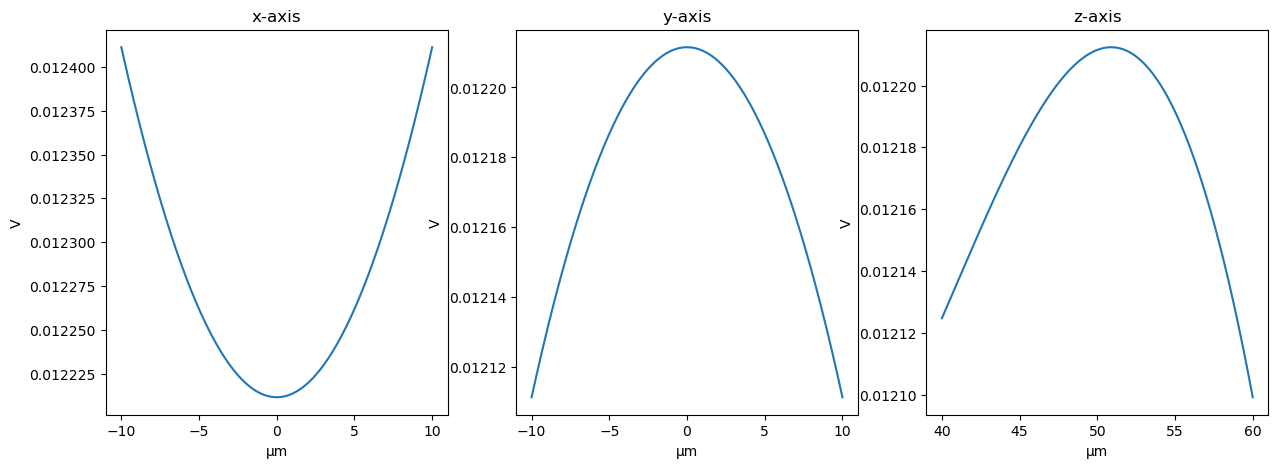

In [53]:
electrode_voltages = np.zeros(len(s.names))
for i in range(len(groups)):
    # group_coeffs = np.zeros(len(b))
    for electrode_name in groups[i]:
        electrode_voltages[s.names.index(electrode_name)] = soln2[i]
print(electrode_voltages)

x3d, x = single_axis('x', (-length/2,length/2), res, shift={'z': 50})
y3d, y = single_axis('y', (-length/2,length/2), res, shift={'z': 50})
z3d, z = single_axis('z', (-length/2,length/2), res, shift={'z': 50})

with s.with_voltages(electrode_voltages):
    vx = s.electrical_potential(x3d).T
    vy = s.electrical_potential(y3d).T
    vz = s.electrical_potential(z3d).T
    print(vx)
    print(x.shape)
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax = ax.flat
    ax[0].plot(x, vx[0], label='x-axis')
    ax[0].set_title('x-axis')
    ax[1].plot(y, vy[0], label='y-axis')
    ax[1].set_title('y-axis')
    ax[2].plot(z +50, vz[0], label='z-axis')
    ax[2].set_title('z-axis')
    for i in range(3):
        ax[i].set_xlabel('µm')
        ax[i].set_ylabel('V')
    # plt.plot(x[45000:55000], 2.04e-6*x[45000:55000]**2)
    # plt.plot(x[:, 0], 2.04e-6*x[:, 0]**2)
    # plt.figure()
    # plt.plot(y[:, 1], vy[0])
    # plt.figure()
    # plt.plot(z[:, 2], vz[0])

In [41]:
temp1 = np.matmul(A_grouped.T, soln2)
print(temp1)
print(np.allclose(temp1, b))
print(b - temp1)

[ 0.00000000e+00  4.00000000e-06  0.00000000e+00 -2.00000000e-06
 -2.16840434e-19 -2.00000000e-06]
True
[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.96461532e-21
 2.16840434e-19 2.96461532e-21]


In [34]:
print(z3d)

[[ 0.     0.    50.   ]
 [ 0.     0.    50.001]
 [ 0.     0.    50.002]
 ...
 [ 0.     0.    59.998]
 [ 0.     0.    59.999]
 [ 0.     0.    60.   ]]


2019 v2

In [15]:
# electrode_voltages = np.zeros(len(s.names))
# for i in range(len(groups)):
#     # group_coeffs = np.zeros(len(b))
#     for electrode_name in groups[i]:
#         electrode_voltages[s.names.index(electrode_name)] = soln2[i]

# 2, 3, 4, 5, 6, 7, 8, 9, 10, 12
# 2019 v1 mapping
# electrode_voltages = np.array([
#     0, 0, 0, 0.58095, -1.6915, 0.58095, 0, 0, 0, 0, 0, 0, 0.58095, -1.6915, 0.58095, 0, 0, 0, -0.24083, -0.24083, 0, 0
# ])
# 2019 v2 mapping
electrode_voltages = np.array([
    2.6378, 2.6378, -2.0898, -2.0898, -2.0898, 2.6378, 2.6378, 0, 0, 2.6378, 2.6378, -2.0898, -2.0898, -2.0898, 2.6378, 2.6378, 0, 0, -0.50453, -0.50453, 0, 0
])
print(electrode_voltages.shape)

x3d, x = single_axis('x', (-length/2,length/2), res)
y3d, y = single_axis('y', (-length/2,length/2), res)
z3d, z = single_axis('z', (-length/2,length/2), res)

with s.with_voltages(electrode_voltages):
    vx = s.electrical_potential(x3d).T
    vy = s.electrical_potential(y3d).T
    vz = s.electrical_potential(z3d).T
    print(vx)
    print(x.shape)
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax = ax.flat
    ax[0].plot(x, vx[0], label='x-axis')
    ax[0].set_title('x-axis')
    ax[1].plot(y, vy[0], label='y-axis')
    ax[1].set_title('y-axis')
    ax[2].plot(z, vz[0], label='z-axis')
    ax[2].set_title('z-axis')
    for i in range(3):
        ax[i].set_xlabel('µm')
        ax[i].set_ylabel('V')
    # plt.plot(x[45000:55000], 2.04e-6*x[45000:55000]**2)
    # plt.plot(x[:, 0], 2.04e-6*x[:, 0]**2)
    # plt.figure()
    # plt.plot(y[:, 1], vy[0])
    # plt.figure()
    # plt.plot(z[:, 2], vz[0])

(22,)


NameError: name 'length' is not defined

Grouping with 7 electrodes

In [22]:

A = np.array(overall_fitted_coeffs)
# clean values below 1e-17
# A[np.abs(A)<1e-17] = 0
# remove constant terms from matrix
A = np.delete(A, [0, 3, 6], 1)
# remove rf and gnd electrodes
A = np.delete(A, [-1, -2], 0)
# print(A)
#b = np.zeros(6)
# b = np.array([0, 2e-6, 0,-1e-6,0,-1e-6])
b = np.array([0, 2e-6,-1e-6,0,-1e-6])
# b = np.array([ 2.04e-6, 0, -1.02e-6, 0, -1.02e-6])
# group electrodes by adding their coefficients
# 1: 4 and 14
# 2: 8 and 18
# 3: 5, 6, 7 and 15, 16, 17
# 4: assume all others grounded

A_grouped = []
#experiment 11/15: try using 3 electrode groups for tilt voltage, since we only need the 2nd order terms
b = np.array([2e-6,-1e-6,-1e-6])
# groups = [['1', '11'], ['3', '13', '4', '14', '8', '18', '9', '19'], ['5', '6', '7', '15', '16', '17']]
groups = [['1', '11'], ['3', '13', '9', '19'], ['4', '14', '5', '6', '7', '15', '16', '17', '8', '18']]


# groups = [['1', '11'], ['4', '14'], ['6', '16'], ['5', '15', '7', '17'], ['8', '18']] # this one actually returns physically feasible results

# groups = [['1'], ['11'], ['4', '14'], ['8', '18'], ['5', '6', '7'], ['15', '16', '17']]
# groups = [['1', '11'], ['4', '8'], ['14', '18'], ['5', '6', '7'], ['15', '16', '17']]
for group in groups:
    # group_coeffs = np.zeros(len(b))
    # group_coeffs = np.zeros(len(b)+1)
    group_coeffs = np.zeros(6)
    for electrode_name in group:
        # print(group_coeffs.shape)
        # print(np.array(A[s.names.index(electrode_name)]).shape)
        # group_coeffs = group_coeffs + np.array(A[np.where(s.names == electrode_name)]).flatten()
        group_coeffs += np.array(A[s.names.index(electrode_name)])
        # print(group_coeffs)
    # for item in range(len(group_coeffs)):
    #     if(np.abs(group_coeffs[item]) < 1e-17):
    #         group_coeffs[item] = 0
    # print(group_coeffs)
    A_grouped.append(group_coeffs)
# target [c_x0, c_x1, c_x2, c_x0, c_x1, c_x2]
# endcap from Allcock paper
# b = np.array([0, -1.02e-6, 0, -1.02e-6, 0, 2.04e-6])
A_grouped = np.array(A_grouped)
A_grouped[np.abs(A_grouped)<1e-17] = 0
# for i in range(A_grouped.shape[1]):
#     column = i%2
#     A_grouped[:,i] = A_grouped[:,i] * 10**(6+(i%2)*6)
    # A_grouped[:,1] = A_grouped[:,1] * 1e12

# needed to delete empty row
print(A_grouped)
A_grouped = np.delete(A_grouped, [0, 2, 4], 1)

print(A_grouped)
# soln1 = np.linalg.solve(np.matmul(A_grouped, A_grouped.T), np.matmul(A_grouped, b))
soln2 = np.linalg.solve(A_grouped.T, b)
# soln2 = np.linalg.lstsq(A_grouped, b.T, rcond=None)
# print(soln1)

print(soln2)

[[ 0.00000000e+00 -2.08922316e-09  0.00000000e+00 -8.01547350e-05
  -5.12142484e-03  8.18247073e-05]
 [ 0.00000000e+00  3.08393543e-07  0.00000000e+00  6.99519894e-08
   3.78750814e-04 -3.78123397e-07]
 [ 0.00000000e+00 -5.55088114e-07  0.00000000e+00  2.03441467e-05
   3.32755352e-03 -1.96844771e-05]]
[[-2.08922316e-09 -8.01547350e-05  8.18247073e-05]
 [ 3.08393543e-07  6.99519894e-08 -3.78123397e-07]
 [-5.55088114e-07  2.03441467e-05 -1.96844771e-05]]
[ 2.89304307e-03  6.37780981e+00 -5.96854417e-02]


[ 0.00000000e+00  6.37780981e+00 -5.96854417e-02 -5.96854417e-02
 -5.96854417e-02 -5.96854417e-02 -5.96854417e-02  6.37780981e+00
  0.00000000e+00  0.00000000e+00  6.37780981e+00 -5.96854417e-02
 -5.96854417e-02 -5.96854417e-02 -5.96854417e-02 -5.96854417e-02
  6.37780981e+00  0.00000000e+00  2.89304307e-03  2.89304307e-03
  0.00000000e+00  0.00000000e+00]
[[0.29619709 0.29621739 0.29623769 ... 0.29623769 0.29621739 0.29619709]]
(100001,)
[-500.   -499.99 -499.98 ...  499.98  499.99  500.  ]


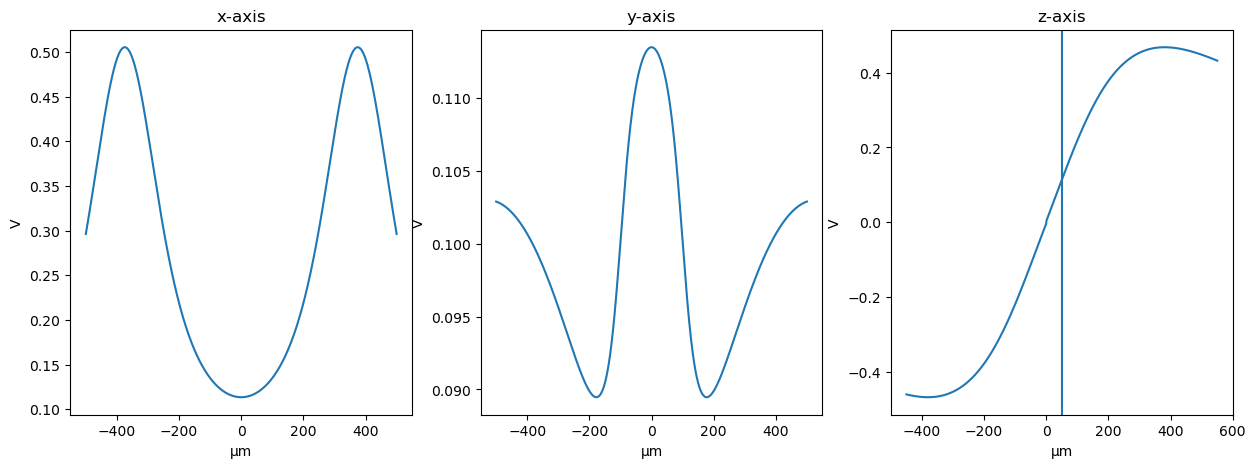

In [24]:
electrode_voltages = np.zeros(len(s.names))
for i in range(len(groups)):
    # group_coeffs = np.zeros(len(b))
    for electrode_name in groups[i]:
        electrode_voltages[s.names.index(electrode_name)] = soln2[i]
print(electrode_voltages)
tmp_len = 1000
x3d, x = single_axis('x', (-tmp_len/2,tmp_len/2), res)
y3d, y = single_axis('y', (-tmp_len/2,tmp_len/2), res)
z3d, z = single_axis('z', (-tmp_len/2,tmp_len/2), res)

with s.with_voltages(electrode_voltages):
    vx = s.electrical_potential(x3d).T
    vy = s.electrical_potential(y3d).T
    vz = s.electrical_potential(z3d).T
    print(vx)
    print(x.shape)
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax = ax.flat
    ax[0].plot(x, vx[0], label='x-axis')
    ax[0].set_title('x-axis')
    ax[1].plot(y, vy[0], label='y-axis')
    ax[1].set_title('y-axis')
    ax[2].plot(z+50, vz[0], label='z-axis')
    ax[2].set_title('z-axis')
    ax[2].axvline(x=50)
    for i in range(3):
        ax[i].set_xlabel('µm')
        ax[i].set_ylabel('V')

print(z)

y-comp

In [215]:

A = np.array(overall_fitted_coeffs)
# clean values below 1e-17
# A[np.abs(A)<1e-17] = 0
# remove constant terms from matrix
A = np.delete(A, [0, 3, 6], 1)
# remove rf and gnd electrodes
A = np.delete(A, [-1, -2], 0)
# print(A)
#b = np.zeros(6)
b = np.array([0, 0, 1e-6, 0, 0, 0])
# b = np.array([0, 2e-6,-1e-6,0,-1e-6])
# b = np.array([ 2.04e-6, 0, -1.02e-6, 0, -1.02e-6])
# group electrodes by adding their coefficients
# 1: 4 and 14
# 2: 8 and 18
# 3: 5, 6, 7 and 15, 16, 17
# 4: assume all others grounded

A_grouped = []
#experiment 11/15: try using 3 electrode groups for tilt voltage, since we only need the 2nd order terms
# b = np.array([2e-6,-1e-6,-1e-6])
# groups = [['1', '11'], ['3', '13', '4', '14', '8', '18', '9', '19'], ['5', '6', '7', '15', '16', '17']]
# groups = [['1'], ['11'], ['3', '4', '8', '9', '5', '6', '7'], ['13', '14', '18', '19'], ['15', '16', '17']]
groups = [ ['3', '4'], ['8', '9'], ['5', '6', '7'], ['13', '14'], ['18', '19'], ['15', '16', '17']]


# groups = [['1', '11'], ['4', '14'], ['6', '16'], ['5', '15', '7', '17'], ['8', '18']] # this one actually returns physically feasible results

# groups = [['1'], ['11'], ['4', '14'], ['8', '18'], ['5', '6', '7'], ['15', '16', '17']]
# groups = [['1', '11'], ['4', '8'], ['14', '18'], ['5', '6', '7'], ['15', '16', '17']]
for group in groups:
    # group_coeffs = np.zeros(len(b))
    # group_coeffs = np.zeros(len(b)+1)
    group_coeffs = np.zeros(6)
    for electrode_name in group:
        # print(group_coeffs.shape)
        # print(np.array(A[s.names.index(electrode_name)]).shape)
        # group_coeffs = group_coeffs + np.array(A[np.where(s.names == electrode_name)]).flatten()
        group_coeffs += np.array(A[s.names.index(electrode_name)])
        # print(group_coeffs)
    # for item in range(len(group_coeffs)):
    #     if(np.abs(group_coeffs[item]) < 1e-17):
    #         group_coeffs[item] = 0
    # print(group_coeffs)
    A_grouped.append(group_coeffs)
# target [c_x0, c_x1, c_x2, c_x0, c_x1, c_x2]
# endcap from Allcock paper
# b = np.array([0, -1.02e-6, 0, -1.02e-6, 0, 2.04e-6])
A_grouped = np.array(A_grouped)
A_grouped[np.abs(A_grouped)<1e-17] = 0
# for i in range(A_grouped.shape[1]):
#     column = i%2
#     A_grouped[:,i] = A_grouped[:,i] * 10**(6+(i%2)*6)
    # A_grouped[:,1] = A_grouped[:,1] * 1e12

# needed to delete empty row
# print(A_grouped)
# A_grouped = np.delete(A_grouped, [0], 1)

print(A_grouped)
# soln1 = np.linalg.solve(np.matmul(A_grouped, A_grouped.T), np.matmul(A_grouped, b))
soln2 = np.linalg.solve(A_grouped.T, b)
# soln2 = np.linalg.lstsq(A_grouped, b.T, rcond=None)
# print(soln1)

print(soln2)

[[-8.23604607e-05  3.17981154e-07  6.86942868e-05  1.35845340e-07
   2.74615902e-04 -4.53725739e-07]
 [ 8.23604607e-05  3.17981154e-07  6.86942868e-05  1.35845340e-07
   2.74615902e-04 -4.53725739e-07]
 [ 0.00000000e+00 -7.59309600e-07  1.09591919e-03  9.93536624e-06
   1.30406343e-03 -9.13169215e-06]
 [-8.23604607e-05  3.17981154e-07 -6.86942868e-05  1.35845340e-07
   2.74615902e-04 -4.53725739e-07]
 [ 8.23604607e-05  3.17981154e-07 -6.86942868e-05  1.35845340e-07
   2.74615902e-04 -4.53725739e-07]
 [ 0.00000000e+00 -7.59309600e-07 -1.09591919e-03  9.93536624e-06
   1.30406343e-03 -9.13169215e-06]]
[ 0.00265184 -0.005365    0.0006263  -0.00265184  0.005365   -0.0006263 ]


In [217]:
temp1 = np.matmul(A_grouped.T, soln2)
print(temp1)
print(np.allclose(temp1, b))
print(b - temp1)

[ 1.05879118e-22 -1.24077092e-24  1.00000000e-06 -1.65436123e-24
  0.00000000e+00 -2.48154184e-24]
True
[-1.05879118e-22  1.24077092e-24 -2.11758237e-22  1.65436123e-24
  0.00000000e+00  2.48154184e-24]


[ 0.          0.00265184  0.00265184  0.0006263   0.0006263   0.0006263
 -0.005365   -0.005365    0.          0.         -0.00265184 -0.00265184
 -0.0006263  -0.0006263  -0.0006263   0.005365    0.005365    0.
  0.          0.          0.          0.        ]
[[1.16212920e-18 1.02660393e-18 1.25360876e-18 ... 7.04731412e-19
  1.08420217e-18 9.21571847e-19]]
(100001,)


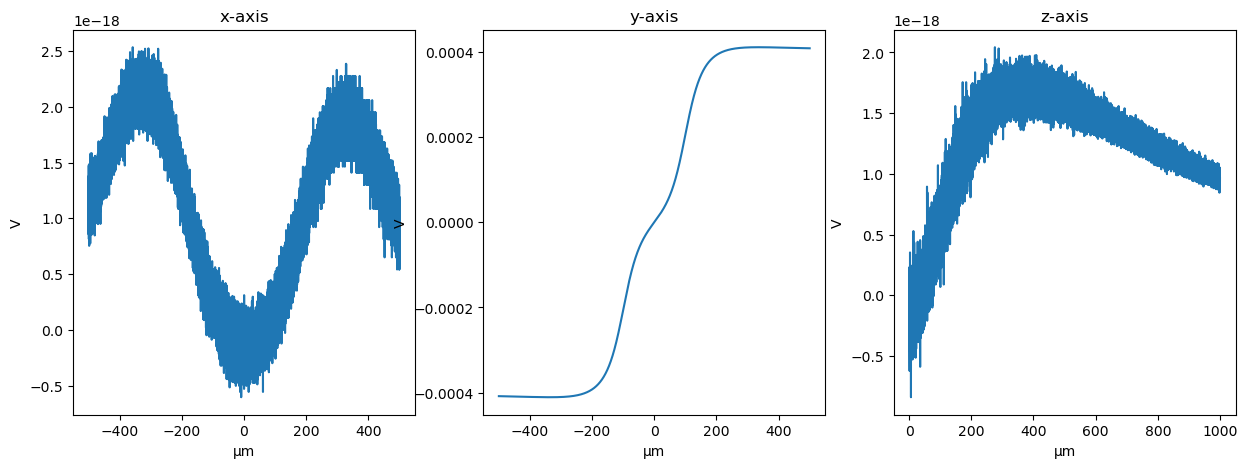

In [216]:
electrode_voltages = np.zeros(len(s.names))
for i in range(len(groups)):
    # group_coeffs = np.zeros(len(b))
    for electrode_name in groups[i]:
        electrode_voltages[s.names.index(electrode_name)] = soln2[i]
print(electrode_voltages)

x3d, x = single_axis('x', (-length/4,length/4), res)
y3d, y = single_axis('y', (-length/4,length/4), res)
z3d, z = single_axis('z', (0,length/2), res)

with s.with_voltages(electrode_voltages):
    vx = s.electrical_potential(x3d).T
    vy = s.electrical_potential(y3d).T
    vz = s.electrical_potential(z3d).T
    print(vx)
    print(x.shape)
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax = ax.flat
    ax[0].plot(x, vx[0], label='x-axis')
    ax[0].set_title('x-axis')
    ax[1].plot(y, vy[0], label='y-axis')
    ax[1].set_title('y-axis')
    ax[2].plot(z, vz[0], label='z-axis')
    ax[2].set_title('z-axis')
    for i in range(3):
        ax[i].set_xlabel('µm')
        ax[i].set_ylabel('V')

In [218]:

A = np.array(overall_fitted_coeffs)
# clean values below 1e-17
# A[np.abs(A)<1e-17] = 0
# remove constant terms from matrix
A = np.delete(A, [0, 3, 6], 1)
# remove rf and gnd electrodes
A = np.delete(A, [-1, -2], 0)
# print(A)
#b = np.zeros(6)
b = np.array([0, 0, 0, 0, 1e-6, 0])
# b = np.array([0, 2e-6,-1e-6,0,-1e-6])
# b = np.array([ 2.04e-6, 0, -1.02e-6, 0, -1.02e-6])
# group electrodes by adding their coefficients
# 1: 4 and 14
# 2: 8 and 18
# 3: 5, 6, 7 and 15, 16, 17
# 4: assume all others grounded

A_grouped = []
#experiment 11/15: try using 3 electrode groups for tilt voltage, since we only need the 2nd order terms
# b = np.array([2e-6,-1e-6,-1e-6])
# groups = [['1', '11'], ['3', '13', '4', '14', '8', '18', '9', '19'], ['5', '6', '7', '15', '16', '17']]
# groups = [['1'], ['11'], ['3', '4', '8', '9', '5', '6', '7'], ['13', '14', '18', '19'], ['15', '16', '17']]
groups = [ ['3', '4'], ['8', '9'], ['5', '6', '7'], ['13', '14'], ['18', '19'], ['15', '16', '17']]


# groups = [['1', '11'], ['4', '14'], ['6', '16'], ['5', '15', '7', '17'], ['8', '18']] # this one actually returns physically feasible results

# groups = [['1'], ['11'], ['4', '14'], ['8', '18'], ['5', '6', '7'], ['15', '16', '17']]
# groups = [['1', '11'], ['4', '8'], ['14', '18'], ['5', '6', '7'], ['15', '16', '17']]
for group in groups:
    # group_coeffs = np.zeros(len(b))
    # group_coeffs = np.zeros(len(b)+1)
    group_coeffs = np.zeros(6)
    for electrode_name in group:
        # print(group_coeffs.shape)
        # print(np.array(A[s.names.index(electrode_name)]).shape)
        # group_coeffs = group_coeffs + np.array(A[np.where(s.names == electrode_name)]).flatten()
        group_coeffs += np.array(A[s.names.index(electrode_name)])
        # print(group_coeffs)
    # for item in range(len(group_coeffs)):
    #     if(np.abs(group_coeffs[item]) < 1e-17):
    #         group_coeffs[item] = 0
    # print(group_coeffs)
    A_grouped.append(group_coeffs)
# target [c_x0, c_x1, c_x2, c_x0, c_x1, c_x2]
# endcap from Allcock paper
# b = np.array([0, -1.02e-6, 0, -1.02e-6, 0, 2.04e-6])
A_grouped = np.array(A_grouped)
A_grouped[np.abs(A_grouped)<1e-17] = 0
# for i in range(A_grouped.shape[1]):
#     column = i%2
#     A_grouped[:,i] = A_grouped[:,i] * 10**(6+(i%2)*6)
    # A_grouped[:,1] = A_grouped[:,1] * 1e12

# needed to delete empty row
# print(A_grouped)
# A_grouped = np.delete(A_grouped, [0], 1)

print(A_grouped)
# soln1 = np.linalg.solve(np.matmul(A_grouped, A_grouped.T), np.matmul(A_grouped, b))
soln2 = np.linalg.solve(A_grouped.T, b)
# soln2 = np.linalg.lstsq(A_grouped, b.T, rcond=None)
# print(soln1)

print(soln2)

[[-8.23604607e-05  3.17981154e-07  6.86942868e-05  1.35845340e-07
   2.74615902e-04 -4.53725739e-07]
 [ 8.23604607e-05  3.17981154e-07  6.86942868e-05  1.35845340e-07
   2.74615902e-04 -4.53725739e-07]
 [ 0.00000000e+00 -7.59309600e-07  1.09591919e-03  9.93536624e-06
   1.30406343e-03 -9.13169215e-06]
 [-8.23604607e-05  3.17981154e-07 -6.86942868e-05  1.35845340e-07
   2.74615902e-04 -4.53725739e-07]
 [ 8.23604607e-05  3.17981154e-07 -6.86942868e-05  1.35845340e-07
   2.74615902e-04 -4.53725739e-07]
 [ 0.00000000e+00 -7.59309600e-07 -1.09591919e-03  9.93536624e-06
   1.30406343e-03 -9.13169215e-06]]
[ 3.27545141e+09  2.28906394e+10 -1.64014005e+09 -3.27545141e+09
 -2.28906394e+10  1.64014005e+09]


[ 0.00000000e+00  3.27545141e+09  3.27545141e+09 -1.64014005e+09
 -1.64014005e+09 -1.64014005e+09  2.28906394e+10  2.28906394e+10
  0.00000000e+00  0.00000000e+00 -3.27545141e+09 -3.27545141e+09
  1.64014005e+09  1.64014005e+09  1.64014005e+09 -2.28906394e+10
 -2.28906394e+10  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[[5.28320670e-05 5.23328781e-05 5.09545207e-05 ... 5.31673431e-05
  5.34057617e-05 5.34057617e-05]]
(100001,)


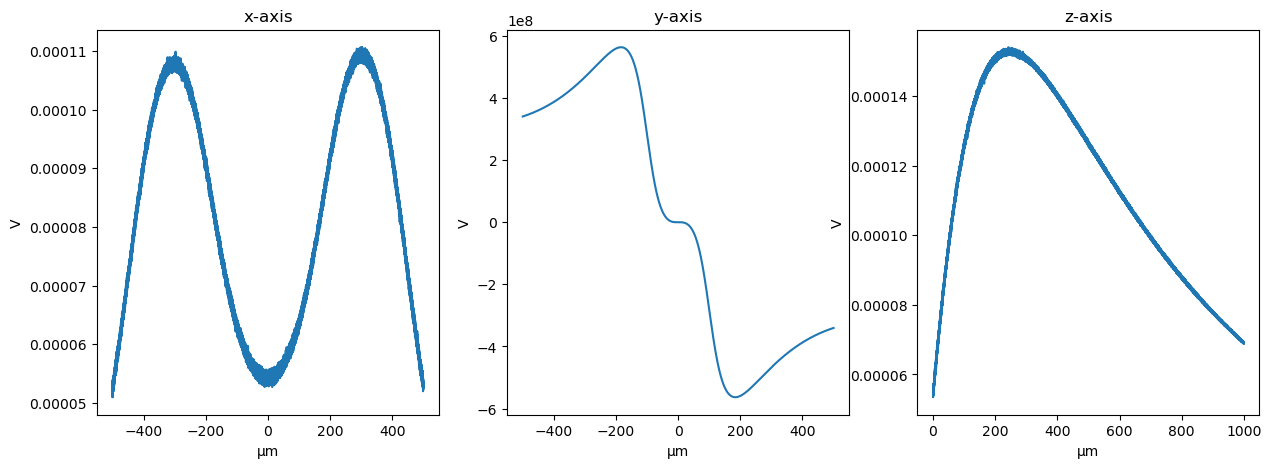

In [219]:
electrode_voltages = np.zeros(len(s.names))
for i in range(len(groups)):
    # group_coeffs = np.zeros(len(b))
    for electrode_name in groups[i]:
        electrode_voltages[s.names.index(electrode_name)] = soln2[i]
print(electrode_voltages)

x3d, x = single_axis('x', (-length/4,length/4), res)
y3d, y = single_axis('y', (-length/4,length/4), res)
z3d, z = single_axis('z', (0,length/2), res)

with s.with_voltages(electrode_voltages):
    vx = s.electrical_potential(x3d).T
    vy = s.electrical_potential(y3d).T
    vz = s.electrical_potential(z3d).T
    print(vx)
    print(x.shape)
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax = ax.flat
    ax[0].plot(x, vx[0], label='x-axis')
    ax[0].set_title('x-axis')
    ax[1].plot(y, vy[0], label='y-axis')
    ax[1].set_title('y-axis')
    ax[2].plot(z, vz[0], label='z-axis')
    ax[2].set_title('z-axis')
    for i in range(3):
        ax[i].set_xlabel('µm')
        ax[i].set_ylabel('V')

Tilt

In [232]:

A = np.array(overall_fitted_coeffs)
# clean values below 1e-17
# A[np.abs(A)<1e-17] = 0
# remove constant terms from matrix
A = np.delete(A, [0, 3, 6], 1)
# remove rf and gnd electrodes
A = np.delete(A, [-1, -2], 0)
# print(A)
#b = np.zeros(6)
b = np.array([0, 1e-7, 0, -1e-7, 0, 0])
# b = np.array([0, 2e-6,-1e-6,0,-1e-6])
# b = np.array([ 2.04e-6, 0, -1.02e-6, 0, -1.02e-6])
# group electrodes by adding their coefficients
# 1: 4 and 14
# 2: 8 and 18
# 3: 5, 6, 7 and 15, 16, 17
# 4: assume all others grounded

A_grouped = []
#experiment 11/15: try using 3 electrode groups for tilt voltage, since we only need the 2nd order terms
# b = np.array([2e-6,-1e-6,-1e-6])
# groups = [['1', '11'], ['3', '13', '4', '14', '8', '18', '9', '19'], ['5', '6', '7', '15', '16', '17']]
# groups = [['1'], ['11'], ['3', '4', '8', '9', '5', '6', '7'], ['13', '14', '18', '19'], ['15', '16', '17']]
# groups = [ ['3', '4'], ['8', '9'], ['5', '6', '7'], ['13', '14'], ['18', '19'], ['15', '16', '17']]
groups = [['1'], ['11'], ['4', '8'], ['5', '6', '7'], ['14', '18'], ['15', '16', '17']]

# groups = [['1', '11'], ['4', '14'], ['6', '16'], ['5', '15', '7', '17'], ['8', '18']] # this one actually returns physically feasible results

# groups = [['1'], ['11'], ['4', '14'], ['8', '18'], ['5', '6', '7'], ['15', '16', '17']]
# groups = [['1', '11'], ['4', '8'], ['14', '18'], ['5', '6', '7'], ['15', '16', '17']]
for group in groups:
    # group_coeffs = np.zeros(len(b))
    # group_coeffs = np.zeros(len(b)+1)
    group_coeffs = np.zeros(6)
    for electrode_name in group:
        # print(group_coeffs.shape)
        # print(np.array(A[s.names.index(electrode_name)]).shape)
        # group_coeffs = group_coeffs + np.array(A[np.where(s.names == electrode_name)]).flatten()
        group_coeffs += np.array(A[s.names.index(electrode_name)])
        # print(group_coeffs)
    # for item in range(len(group_coeffs)):
    #     if(np.abs(group_coeffs[item]) < 1e-17):
    #         group_coeffs[item] = 0
    # print(group_coeffs)
    A_grouped.append(group_coeffs)
# target [c_x0, c_x1, c_x2, c_x0, c_x1, c_x2]
# endcap from Allcock paper
# b = np.array([0, -1.02e-6, 0, -1.02e-6, 0, 2.04e-6])
A_grouped = np.array(A_grouped)
# A_grouped[np.abs(A_grouped)<1e-17] = 0
# for i in range(A_grouped.shape[1]):
#     column = i%2
#     A_grouped[:,i] = A_grouped[:,i] * 10**(6+(i%2)*6)
    # A_grouped[:,1] = A_grouped[:,1] * 1e12

# needed to delete empty row
# print(A_grouped)
# A_grouped = np.delete(A_grouped, [0], 1)

print(A_grouped)
# soln1 = np.linalg.solve(np.matmul(A_grouped, A_grouped.T), np.matmul(A_grouped, b))
soln2 = np.linalg.solve(A_grouped.T, b)
# soln2 = np.linalg.lstsq(A_grouped, b.T, rcond=None)
# print(soln1)

print(soln2)

[[-1.07269609e-19 -1.04461162e-09  1.22999914e-03 -4.00772485e-05
  -2.55396858e-03  4.07863814e-05]
 [-1.02115653e-19 -1.04461162e-09 -1.22999914e-03 -4.00772485e-05
  -2.55396858e-03  4.07863814e-05]
 [-6.77626358e-20  4.81765520e-07  1.03869628e-04  2.36714689e-07
   3.59843773e-04 -7.18358035e-07]
 [ 2.43945489e-19 -7.59309600e-07  1.09591919e-03  9.93536624e-06
   1.30406343e-03 -9.13169215e-06]
 [ 0.00000000e+00  4.81765520e-07 -1.03869628e-04  2.36714689e-07
   3.59843773e-04 -7.18358035e-07]
 [ 1.62630326e-19 -7.59309600e-07 -1.09591919e-03  9.93536624e-06
   1.30406343e-03 -9.13169215e-06]]
[-4.95692050e+09  4.95692050e+09  6.33280927e+09  4.96315921e+09
 -6.33280927e+09 -4.96315921e+09]


[ 0.00000000e+00  0.00000000e+00  6.33280927e+09  4.96315921e+09
  4.96315921e+09  4.96315921e+09  6.33280927e+09  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.33280927e+09
 -4.96315921e+09 -4.96315921e+09 -4.96315921e+09 -6.33280927e+09
  0.00000000e+00  0.00000000e+00 -4.95692050e+09  4.95692050e+09
  0.00000000e+00  0.00000000e+00]
[[-0.00066326 -0.00066286 -0.00066263 ... -0.00066257 -0.00066265
  -0.00066327]]
(100001,)


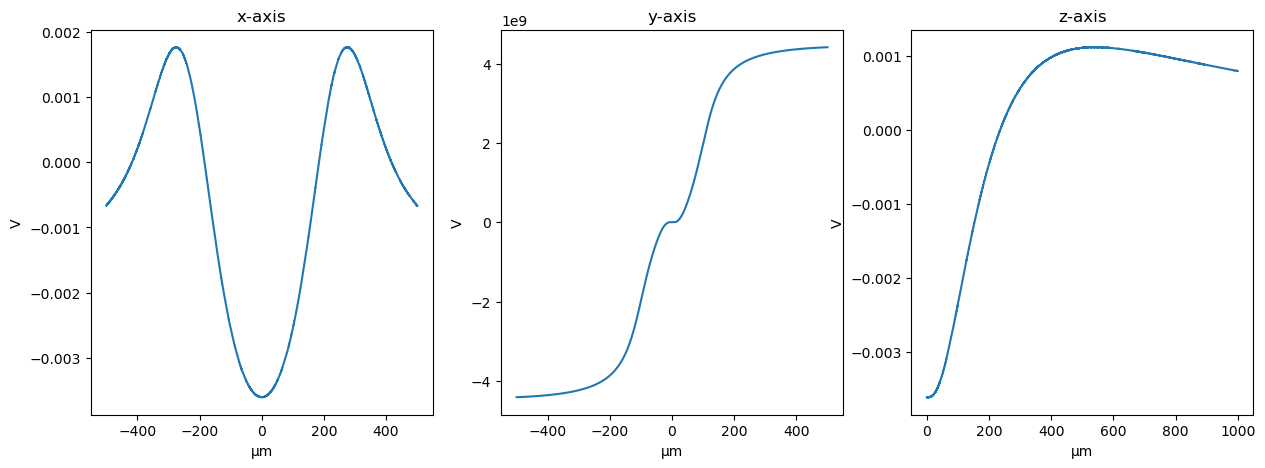

In [233]:
electrode_voltages = np.zeros(len(s.names))
for i in range(len(groups)):
    # group_coeffs = np.zeros(len(b))
    for electrode_name in groups[i]:
        electrode_voltages[s.names.index(electrode_name)] = soln2[i]
print(electrode_voltages)

x3d, x = single_axis('x', (-length/4,length/4), res)
y3d, y = single_axis('y', (-length/4,length/4), res)
z3d, z = single_axis('z', (0,length/2), res)

with s.with_voltages(electrode_voltages):
    vx = s.electrical_potential(x3d).T
    vy = s.electrical_potential(y3d).T
    vz = s.electrical_potential(z3d).T
    print(vx)
    print(x.shape)
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax = ax.flat
    ax[0].plot(x, vx[0], label='x-axis')
    ax[0].set_title('x-axis')
    ax[1].plot(y, vy[0], label='y-axis')
    ax[1].set_title('y-axis')
    ax[2].plot(z, vz[0], label='z-axis')
    ax[2].set_title('z-axis')
    for i in range(3):
        ax[i].set_xlabel('µm')
        ax[i].set_ylabel('V')

Grouping experiment 2

In [275]:

A = np.array(overall_fitted_coeffs)
# remove constant terms from matrix
A = np.delete(A, [0, 3, 6], 1)
# remove rf and gnd electrodes
A = np.delete(A, [-1, -2], 0)
# print(A)

# group electrodes by adding their coefficients
# 1: 4 and 14
# 2: 8 and 18
# 3: 5, 6, 7 and 15, 16, 17
# 4: assume all others grounded

A_grouped = []
groups = [['1', '11'], ['4', '8', '14', '18'], ['5', '6', '7', '15', '16', '17']]
for group in groups:
    group_coeffs = np.zeros(len(b))
    for electrode_name in group:
        # print(group_coeffs.shape)
        # print(np.array(A[s.names.index(electrode_name)]).shape)
        # group_coeffs = group_coeffs + np.array(A[np.where(s.names == electrode_name)]).flatten()
        group_coeffs += np.array(A[s.names.index(electrode_name)])
    # normalizing small components to zero
    # for item in range(len(group_coeffs)):
    #     if(np.abs(group_coeffs[item]) < 1e-17):
    #         group_coeffs[item] = 0
    print(group_coeffs)
    A_grouped.append(group_coeffs)
    # print(group_coeffs)
# target [c_x1, c_x2, c_x0, c_x1, c_x2]
# endcap from Allcock paper
b = np.array([0, 2.04e-6, 0, -1.02e-6, 0, -1.02e-6])
A_grouped = np.array(A_grouped)
print(np.linalg.solve(np.matmul(A_grouped, A_grouped.T), np.matmul(A_grouped, b)))
# print(A_grouped)

[-1.45023518e-18 -2.08922576e-09 -1.30104261e-18 -8.01459921e-05
  8.01459921e-03 -8.01459921e-05]
[ 0.00000000e+00  9.63534787e-07  8.80914265e-20  4.73426175e-07
 -4.73426175e-05  4.73426175e-07]
[-4.87890978e-19 -1.51862462e-06 -2.16840434e-19  1.98712767e-05
 -1.98712767e-03  1.98712767e-05]
[-0.1021258   1.41465244 -0.44561361]


In [165]:
s.names

['2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '1',
 '11',
 'r',
 'gnd']

In [34]:
print(list({'1': 1}.keys()))
for i in {'1': 1}:
    print (type(i))
# {list(axes.keys())[i]}

['1']
<class 'str'>


In [273]:
z = 50 # height of ion above metal in microns
dz = 2
x_max = 750
y_max = 750
x_b = (-x_max, x_max)
y_b = (-y_max, y_max)
z_b = (z - dz, z + dz)

# gr = (200, 200, 20)
gr = (2250, 2250)
xy, tsx, tsy = make_xy_grid_flat(x_b, y_b, z, grid_res=gr)
# xyz, tsx, tsy, tsz = make_xyz_grid_flat(x_b, y_b, z_b, grid_res=gr)
xyz = np.array(xy)
# print(xyz[:, 0])